In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
# import fastgif

In [58]:
@njit()
def HK_2D_step(pos_arr, R):
    '''
    Returns new potion of particles based on neighbors in circle of radius R
    '''
    N = len(pos_arr)
    pos_new = np.empty((N, 2))
    for i in range(N):
        res_pos = np.array([0.0, 0.0])
        count = 0
        for j in range(N):
            if (np.linalg.norm(pos_arr[i] - pos_arr[j]) <= R):
                res_pos += pos_arr[j]
                count += 1

        pos_new[i] = res_pos / count
    return pos_new


def HK_2D_sim(pos_init, R, eps, max_iter):
    '''
    Simulates HK model for 2D particles
    '''
    pos = pos_init.copy()
    pos_t_array = np.empty((0, pos.shape[0], pos.shape[1]), dtype=np.float64)
    pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    for i in range(max_iter):
        pos_new = HK_2D_step(pos, R)
        if np.linalg.norm(pos_new - pos) < eps:
            break
        pos = pos_new
        pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    return pos_t_array, i != max_iter - 1

In [168]:
@njit()
def HK_2D_step_control(pos_arr, R):
    '''
    Returns new potion of particles based on neighbors in circle of radius R
    '''
    N = len(pos_arr)
    pos_new = np.zeros((N, 2))
    for i in range(N-1):
        res_pos = np.array([0.0, 0.0])
        count = 0
        for j in range(N):
            if (np.linalg.norm(pos_arr[i] - pos_arr[j]) <= R):
                res_pos += pos_arr[j]
                count += 1

        pos_new[i] = res_pos / count
    if pos_arr[-1, 0] < 1. and pos_arr[-1, 1] < 1.:
        pos_new[-1] = pos_arr[-1] + np.array([R/N, R/N])
    else:
        pos_new[-1] = np.array([1., 1.])
    return pos_new


def HK_2D_sim_control(pos_init, R, eps, max_iter):
    '''
    Simulates HK model for 2D particles
    '''
    pos = pos_init.copy()
    pos_t_array = np.empty((0, pos.shape[0], pos.shape[1]), dtype=np.float64)
    pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    for i in trange(max_iter):
        pos_new = HK_2D_step_control(pos, R)
        if np.linalg.norm(pos_new - pos) < eps:
            break
        pos = pos_new
        pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    return pos_t_array, i != max_iter - 1

In [59]:
n = 20
S = 1.0
N = n ** 2
init_pos = np.zeros((N, 2), dtype=float)
R = 0.125 + 0.000001
for i in range(n):
    for j in range(n):
        init_pos[i * n + j] = [i / n * S, j / n * S]

In [166]:
init_pos = np.vstack([init_pos, np.array([0.,0.])])

In [60]:
init_pos.shape

(400, 2)

In [62]:
res_arr, check = HK_2D_sim(init_pos, R, R * 1e-3, 10000)
assert(check)

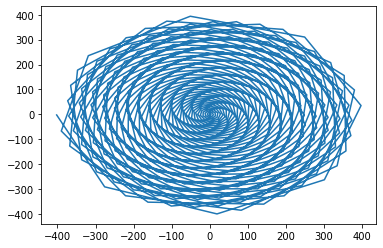

In [256]:
x = []
y = []
for theta in np.linspace(0, (1./R) * (2*np.pi), 500):
    r = 1./R * theta
    x.append(-r*np.cos(r))
    y.append(r*np.sin(r))

plt.plot(x,y)  
plt.show()

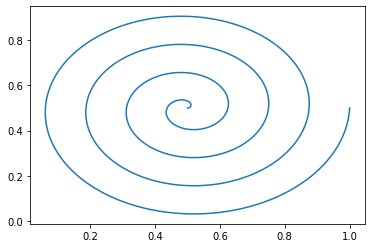

In [4]:
x = []
y = []
for theta in np.linspace(0., 8*np.pi, 500):
    r = R / (2*np.pi) * theta
    x.append(r*np.cos(theta)+0.5)
    y.append(r*np.sin(theta)+0.5)

plt.plot(x,y)  
plt.show()

In [352]:
(R / 2. * 7.) * np.cos(8*np.pi)+0.5

0.06249650000000001

In [6]:
coor = np.vstack([x,y]).T[-1::-1, :]
coor.shape

(500, 2)

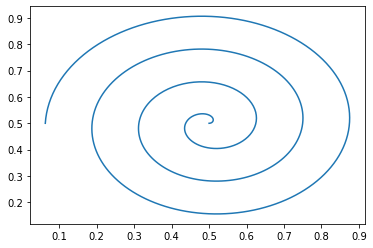

In [314]:
plt.plot(coor[:,0],coor[:,1])  
plt.show()

In [172]:
n = 10
S = 1.0
N = n ** 2
init_pos = np.zeros((N, 2), dtype=float)
R = 0.25 + 0.000001
for i in range(n):
    for j in range(n):
        init_pos[i * n + j] = [i / n * S, j / n * S]

init_pos = np.vstack([init_pos, np.array([0.,0.])])
init_pos.shape
res_arr, check = HK_2D_sim_control(init_pos, R, R * 1e-3, 10000)
assert(check)

  6%|▋         | 636/10000 [00:08<02:03, 75.61it/s]


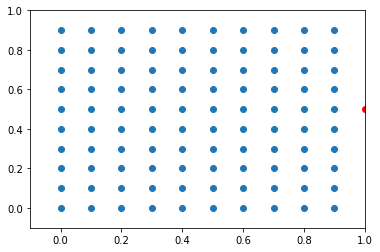

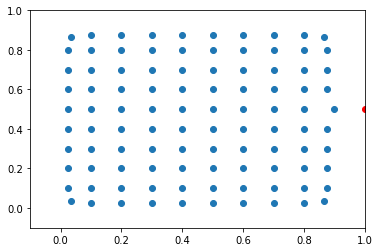

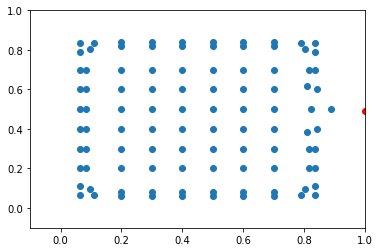

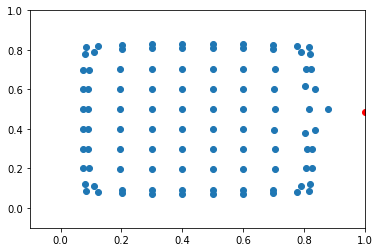

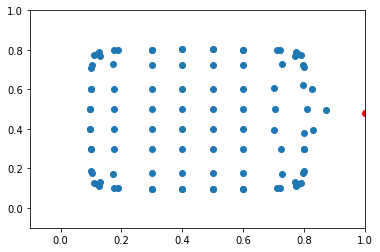

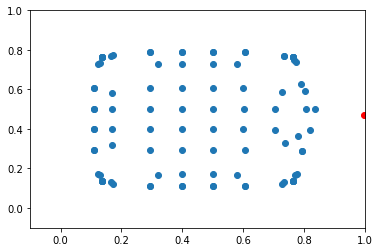

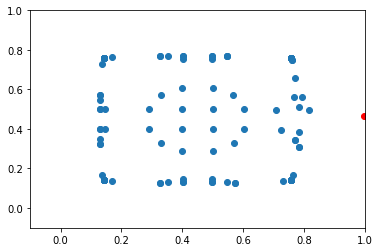

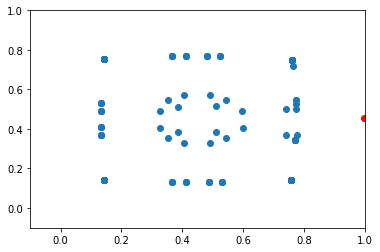

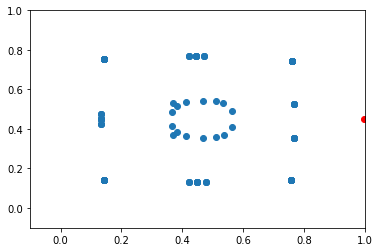

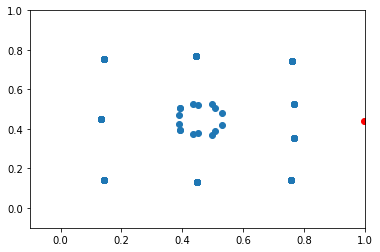

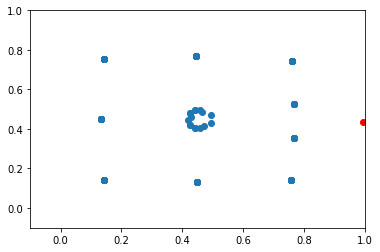

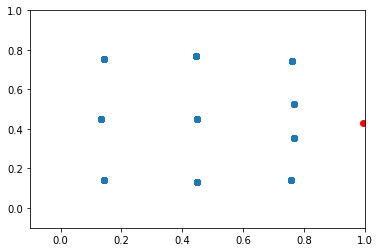

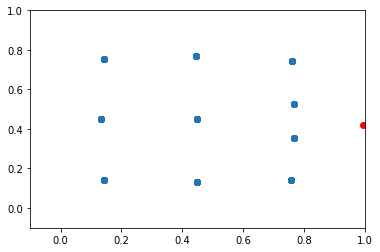

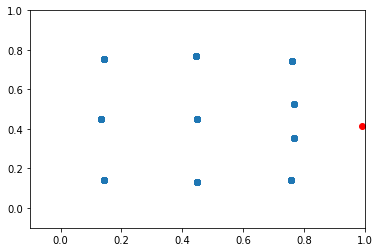

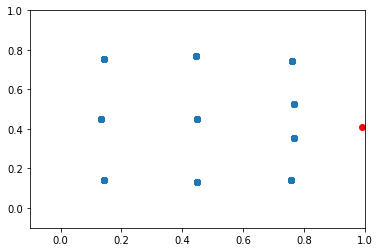

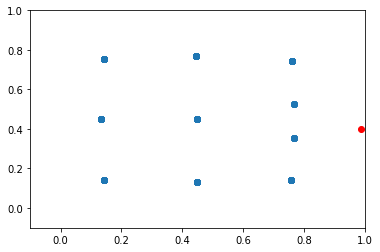

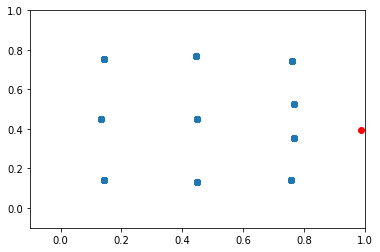

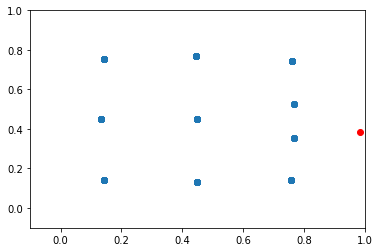

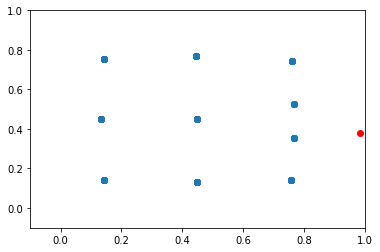

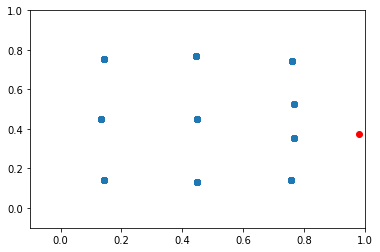

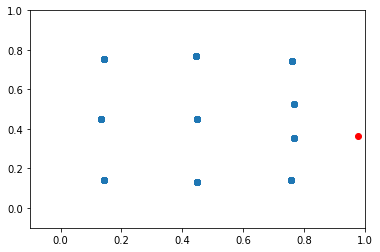

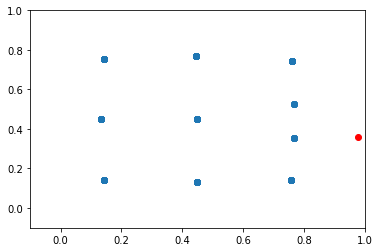

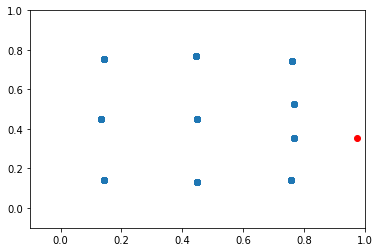

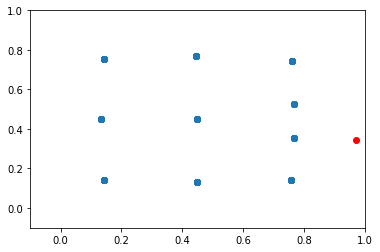

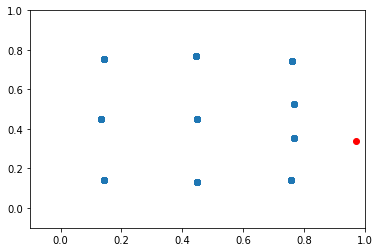

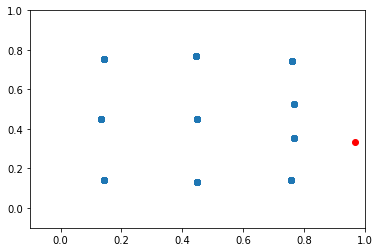

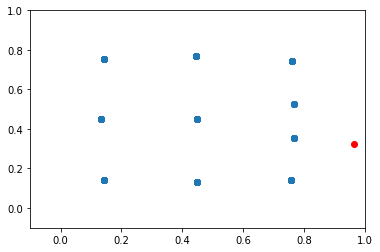

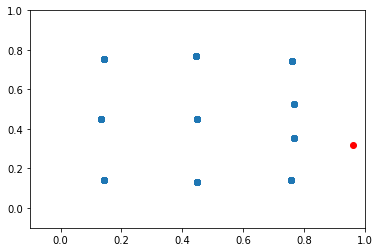

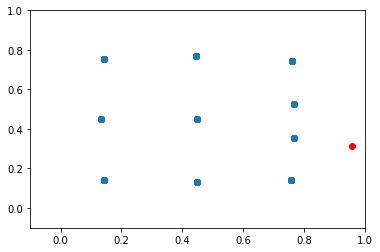

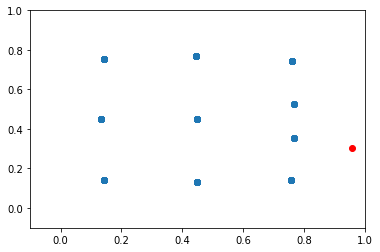

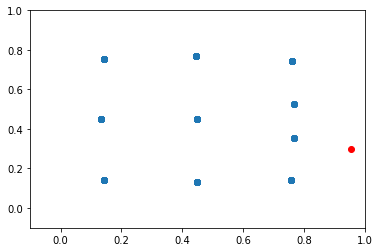

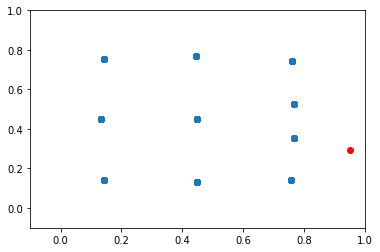

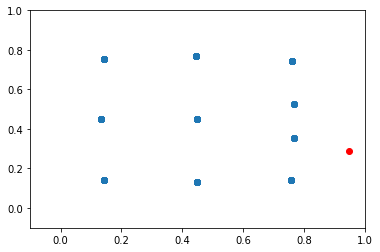

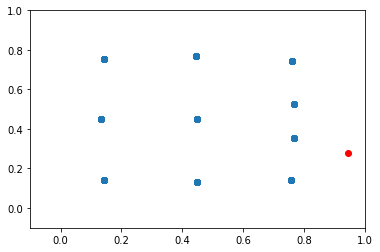

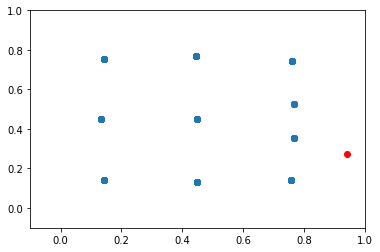

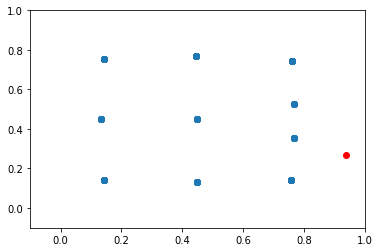

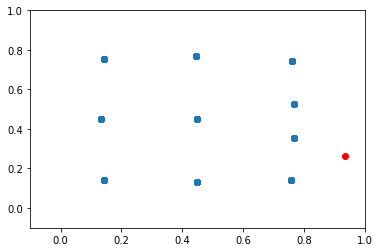

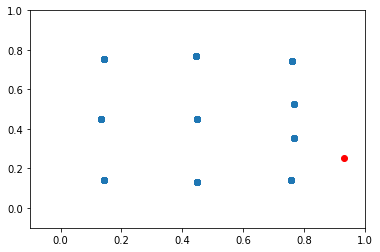

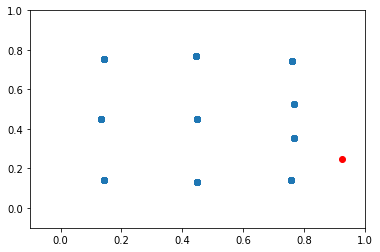

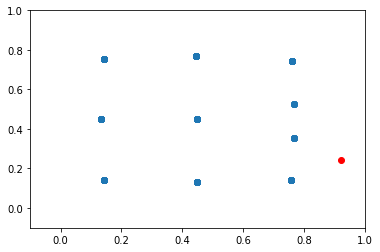

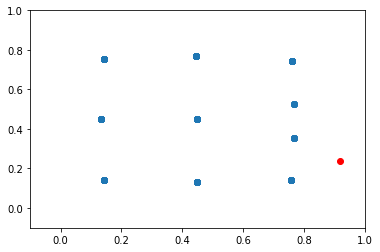

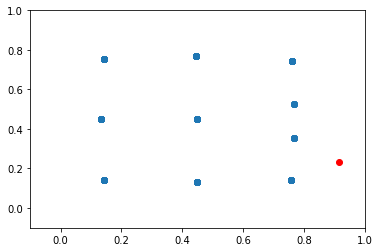

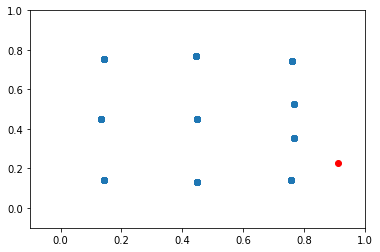

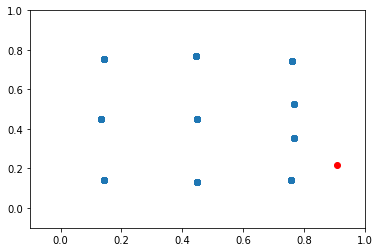

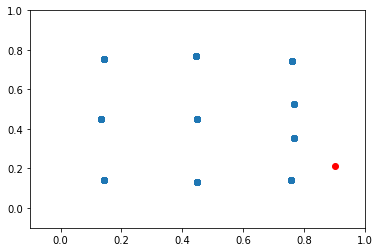

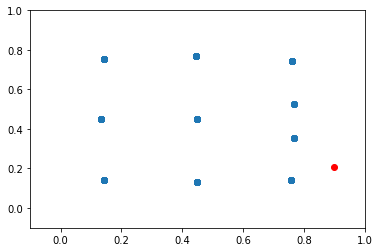

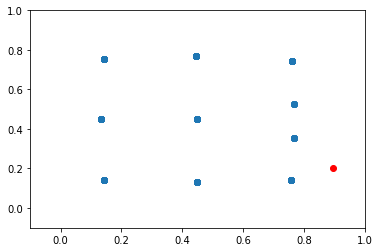

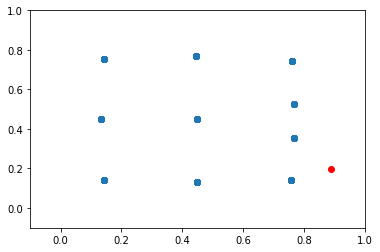

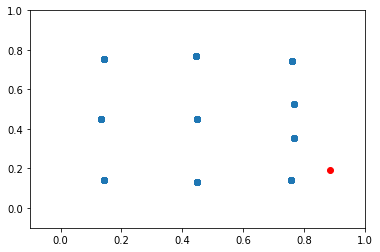

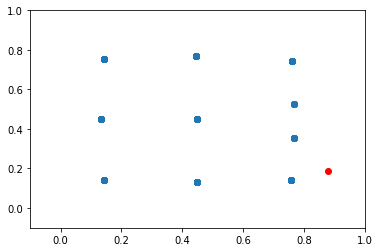

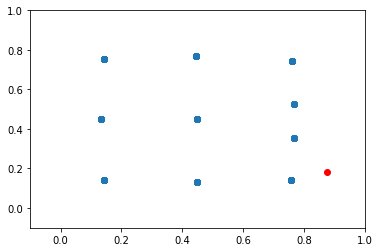

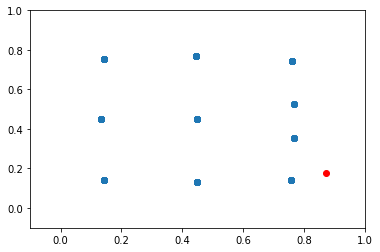

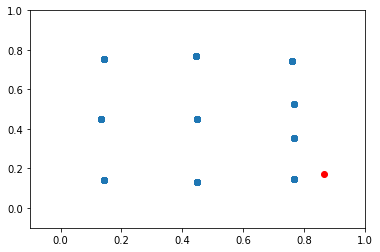

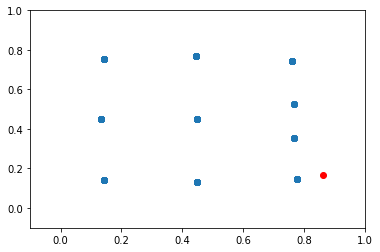

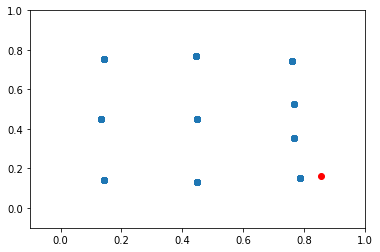

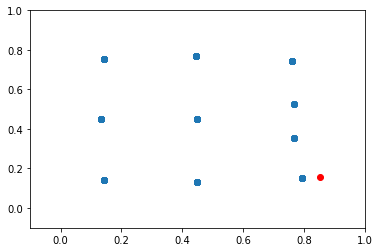

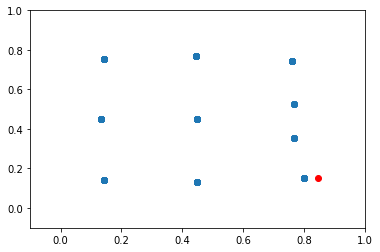

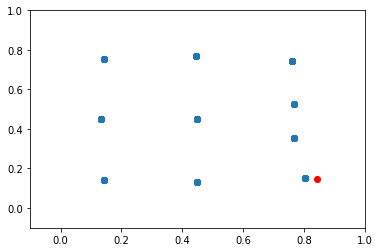

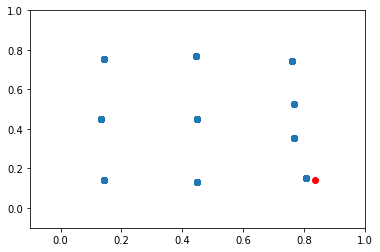

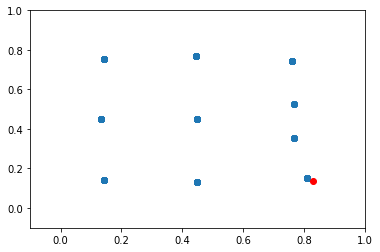

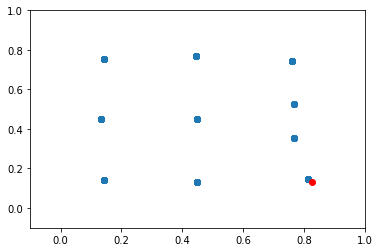

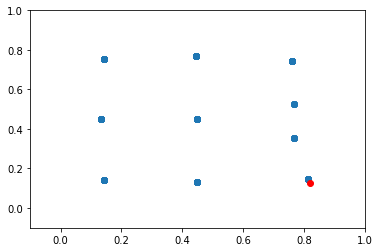

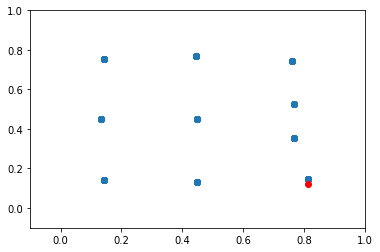

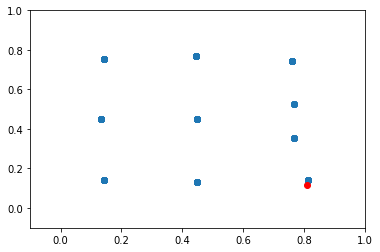

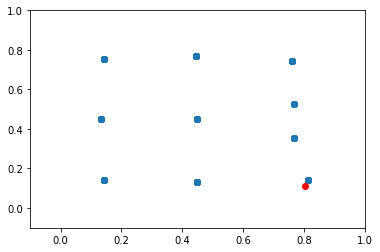

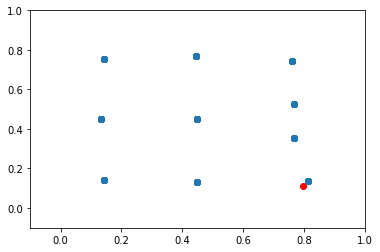

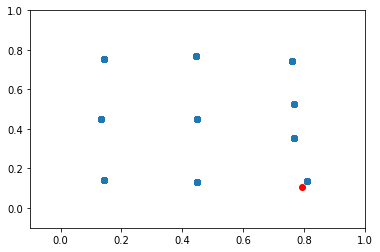

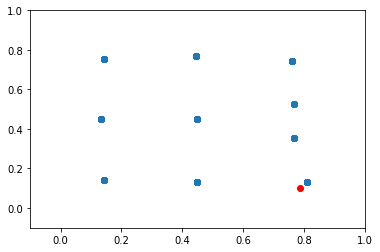

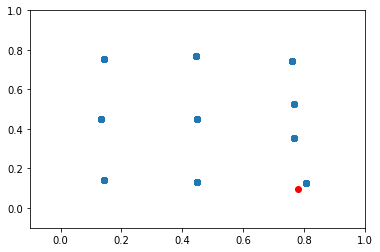

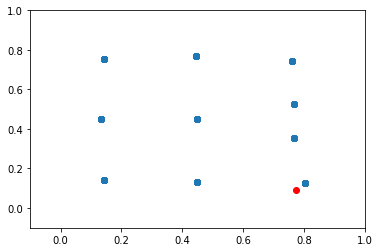

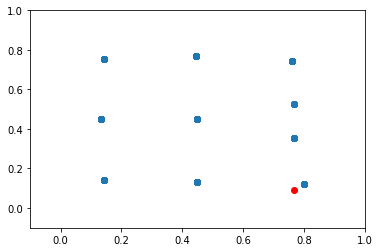

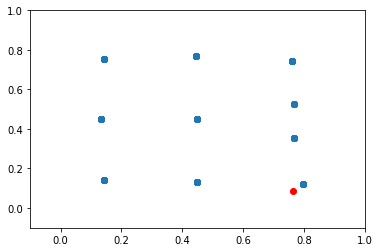

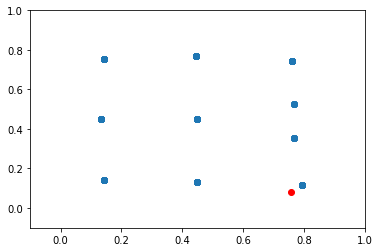

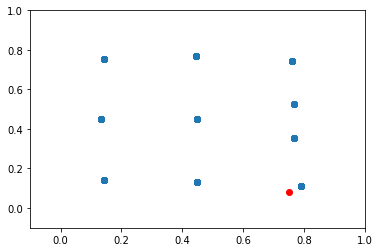

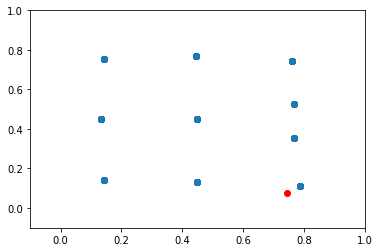

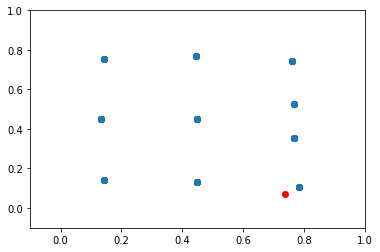

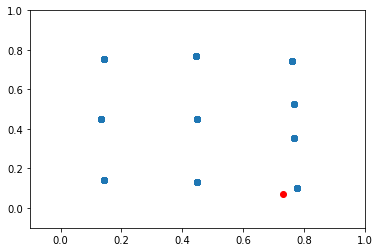

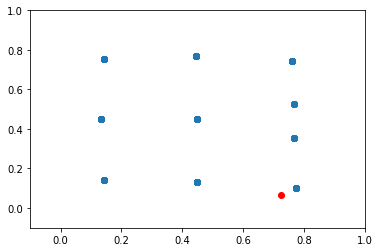

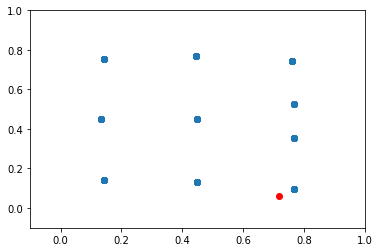

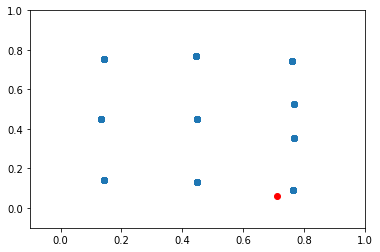

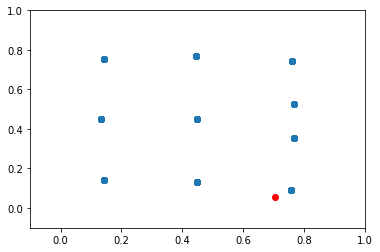

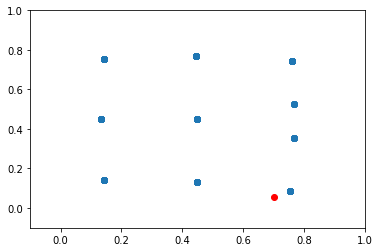

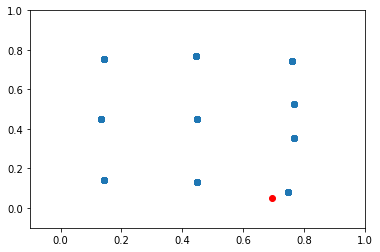

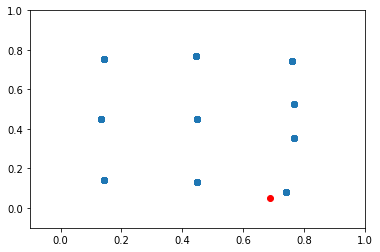

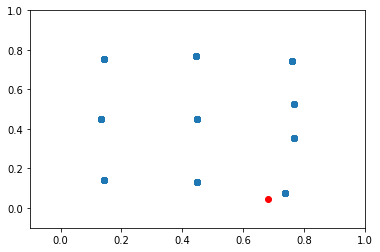

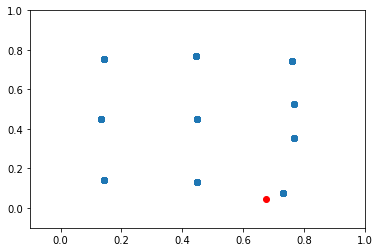

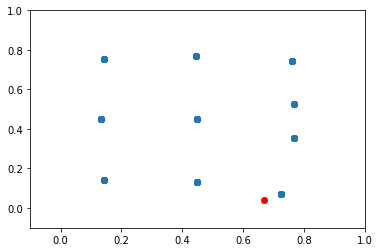

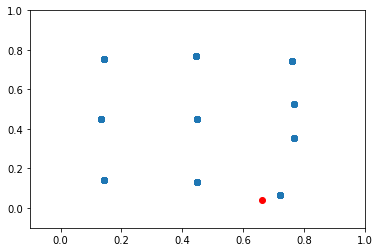

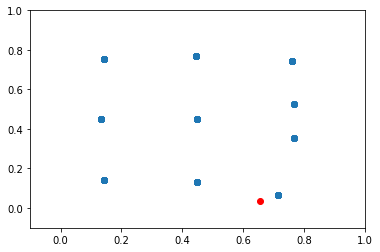

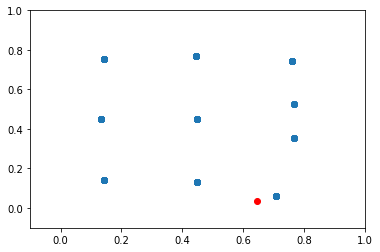

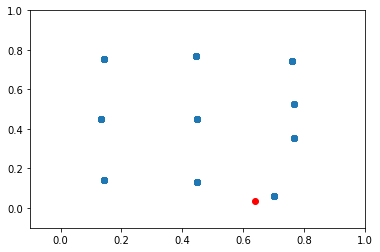

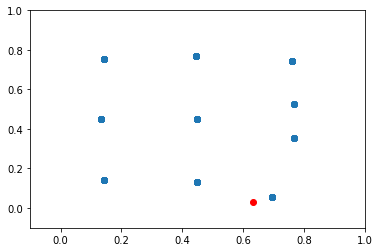

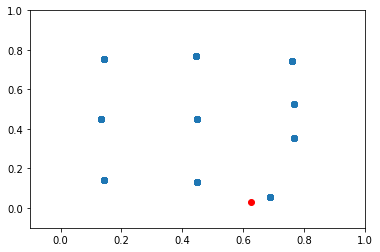

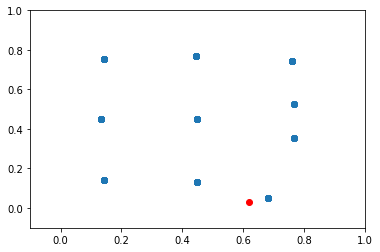

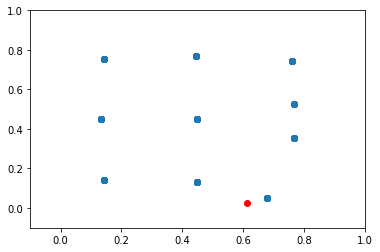

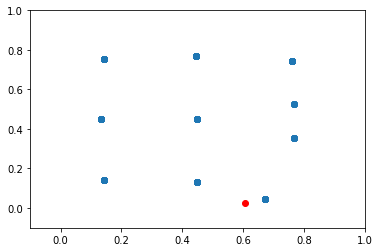

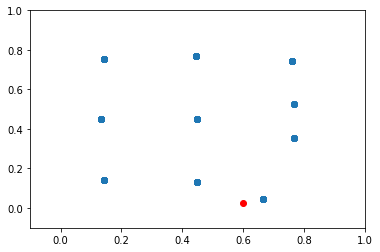

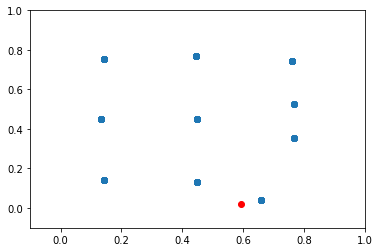

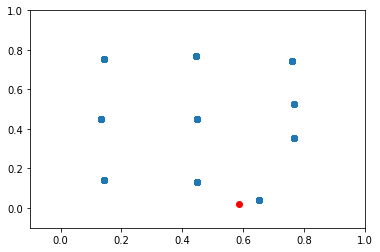

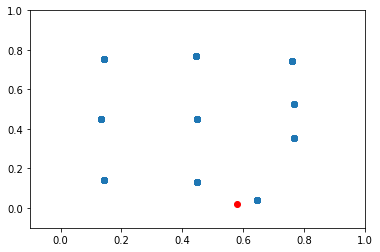

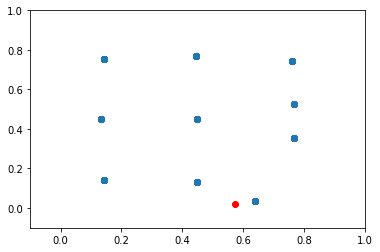

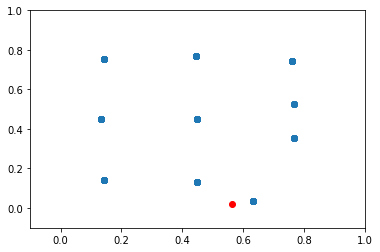

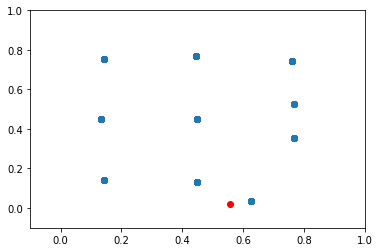

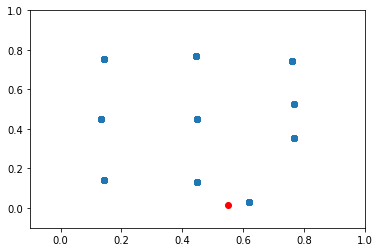

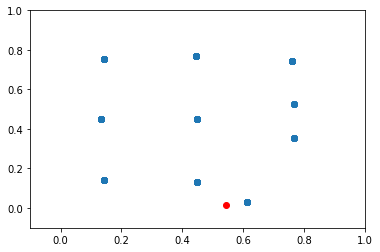

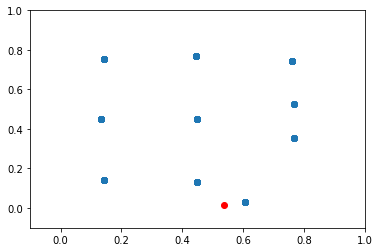

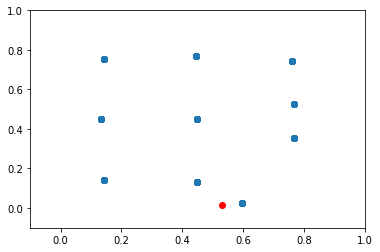

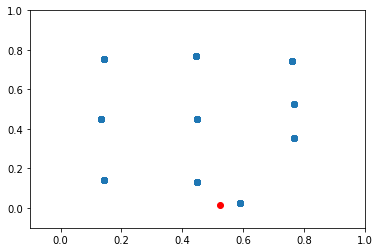

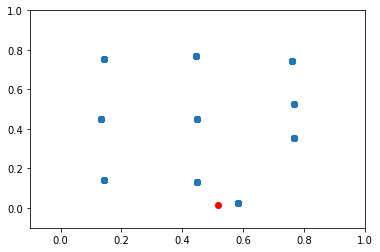

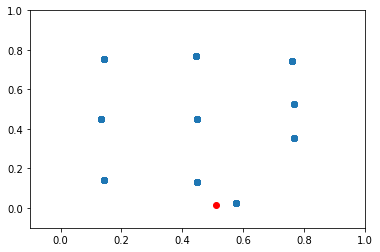

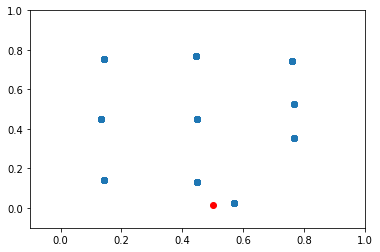

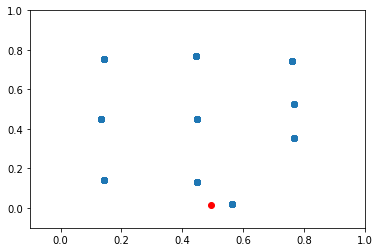

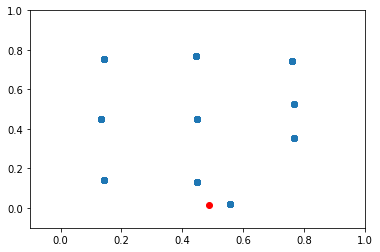

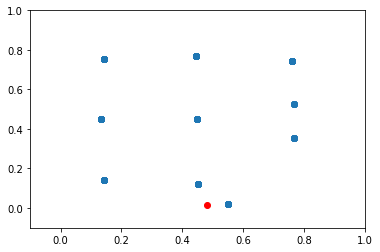

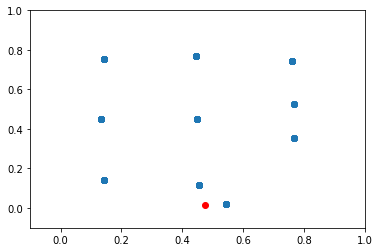

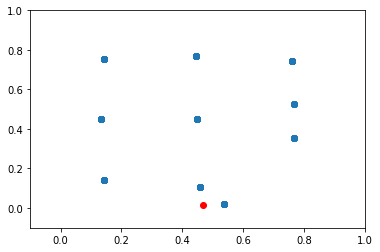

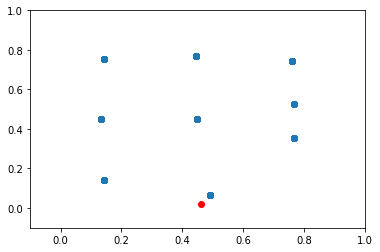

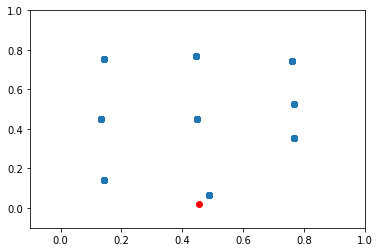

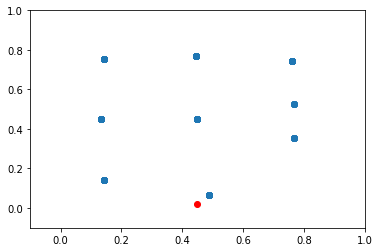

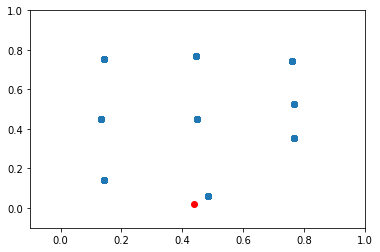

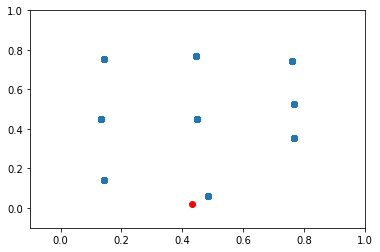

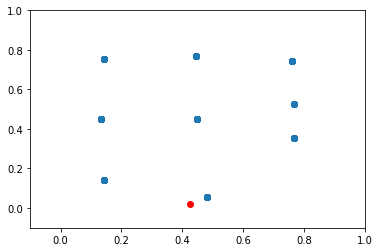

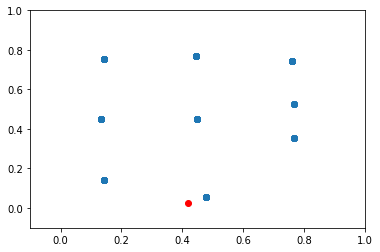

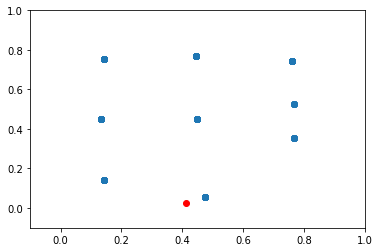

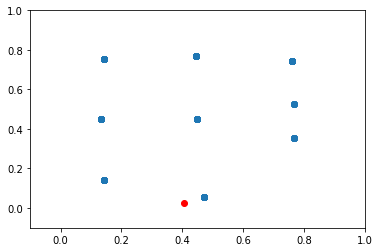

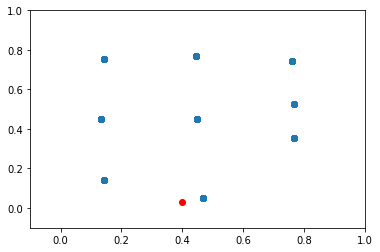

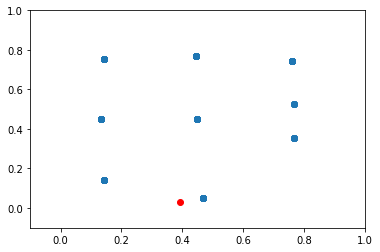

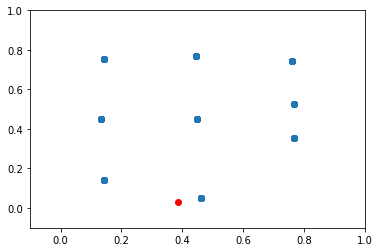

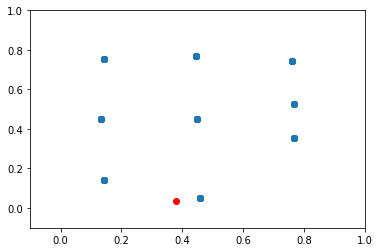

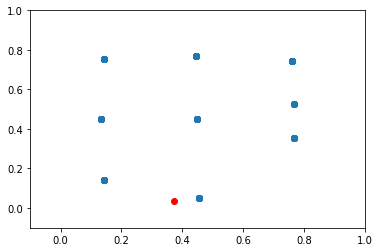

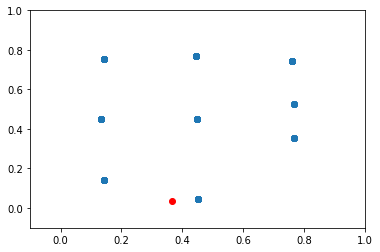

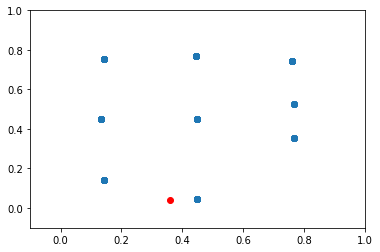

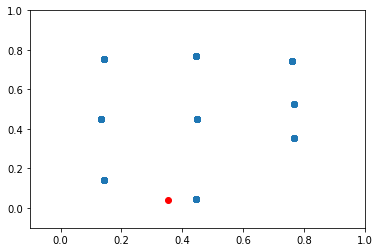

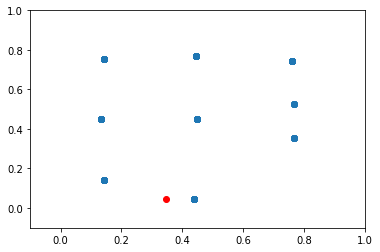

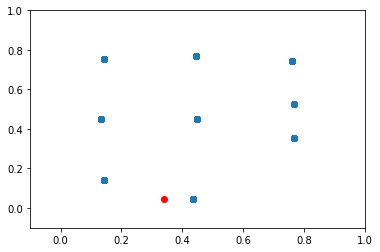

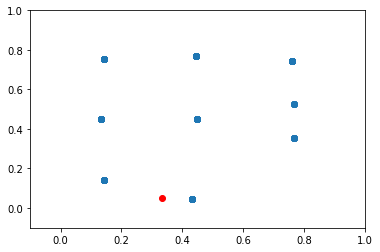

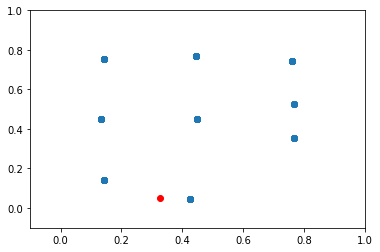

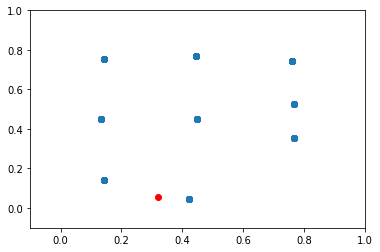

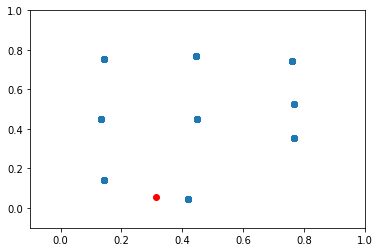

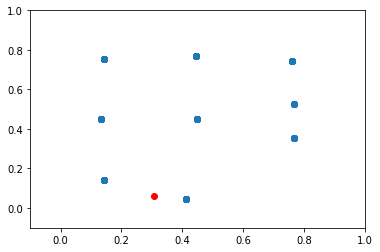

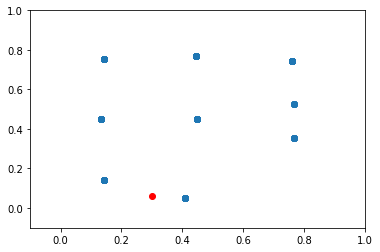

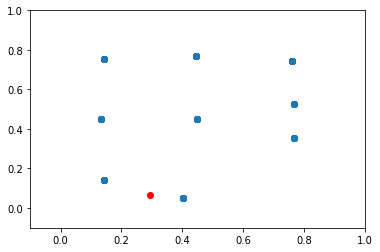

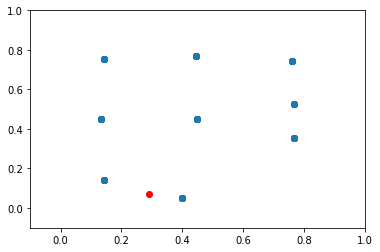

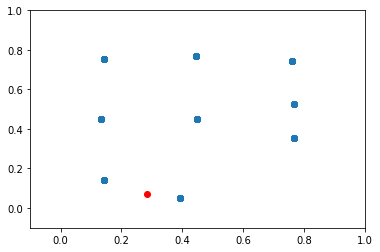

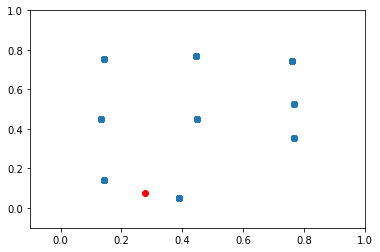

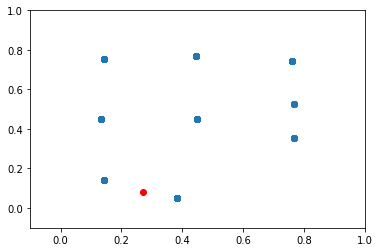

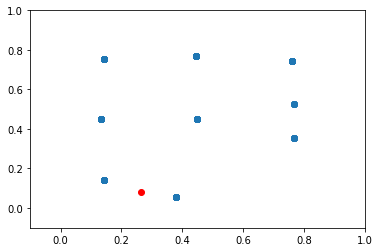

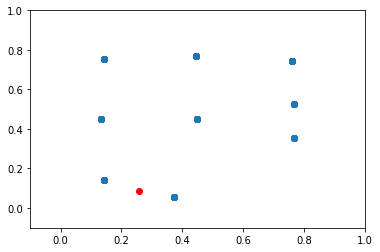

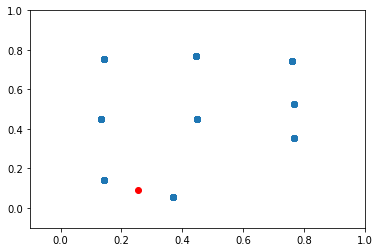

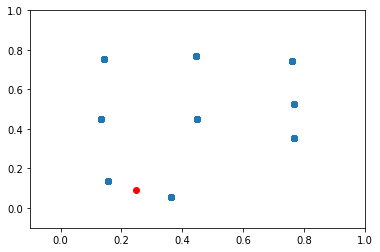

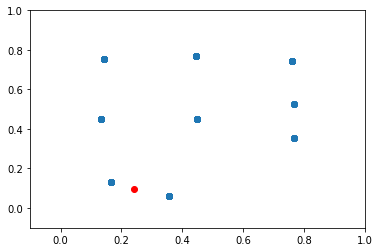

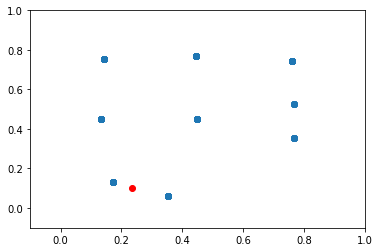

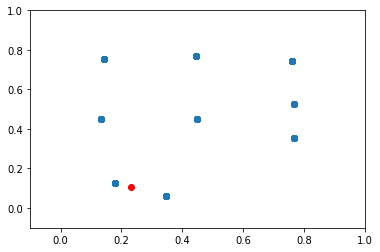

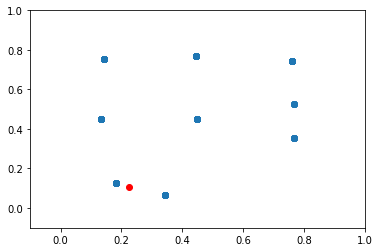

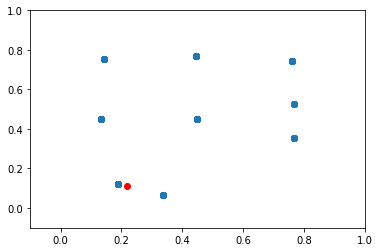

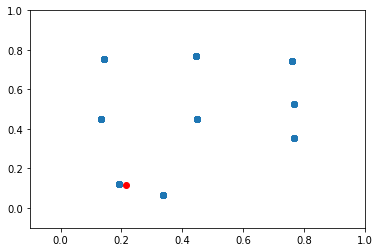

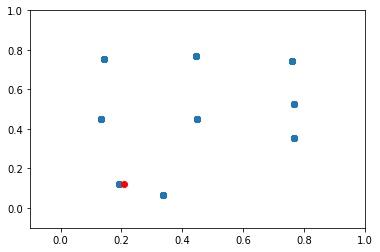

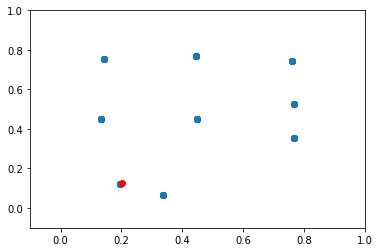

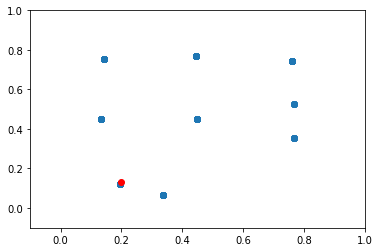

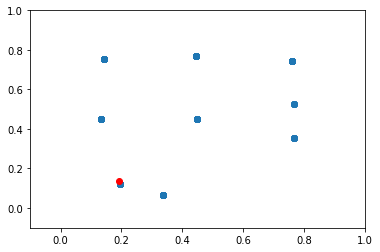

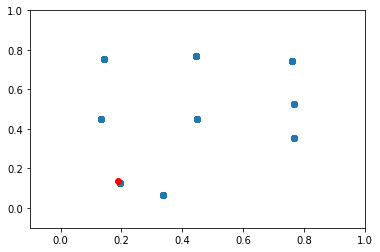

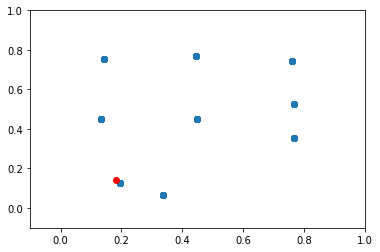

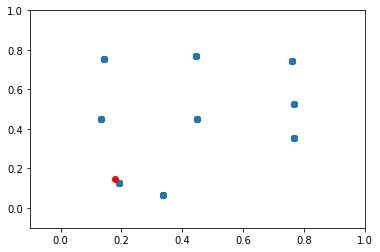

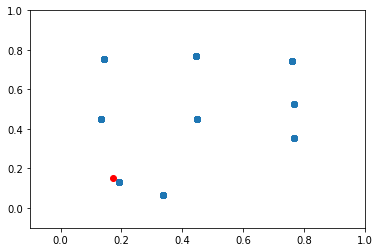

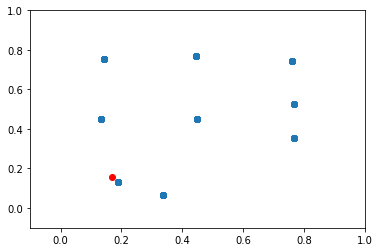

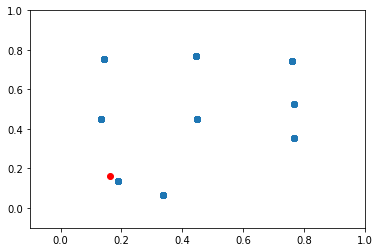

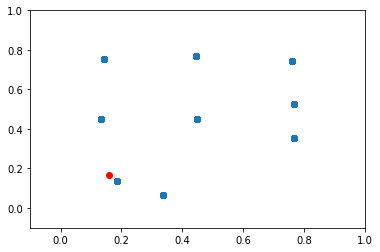

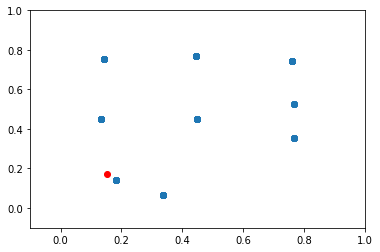

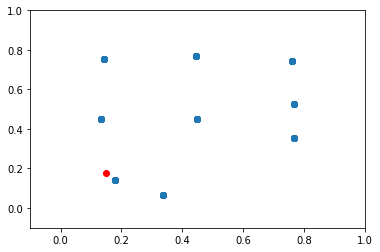

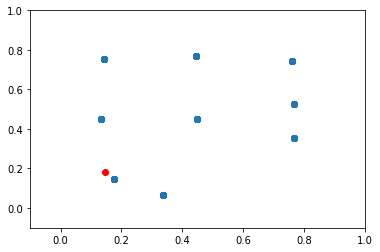

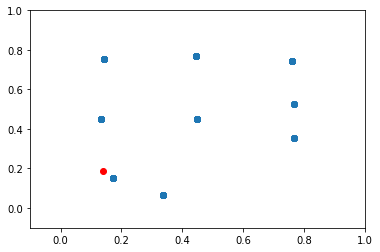

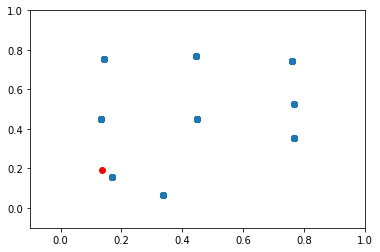

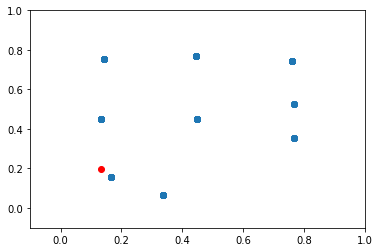

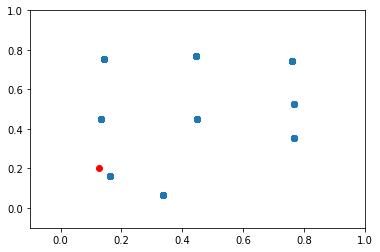

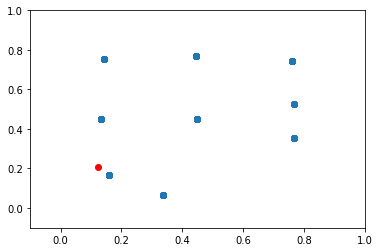

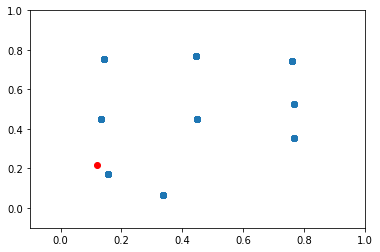

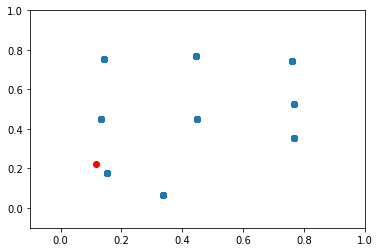

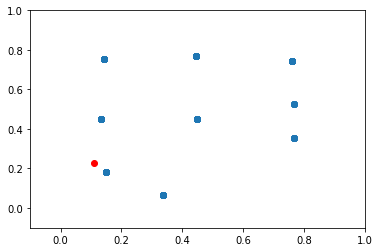

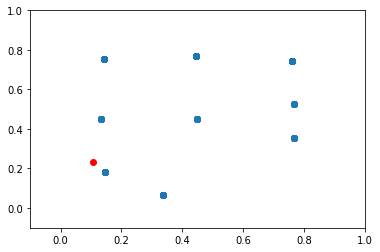

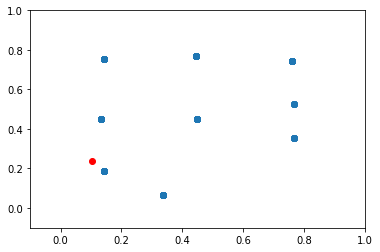

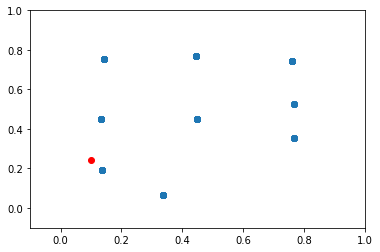

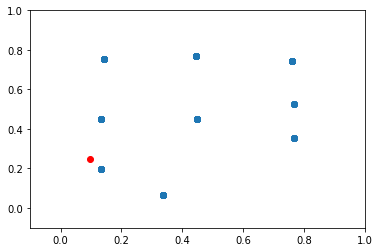

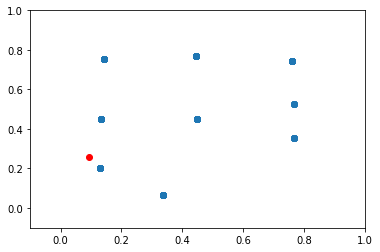

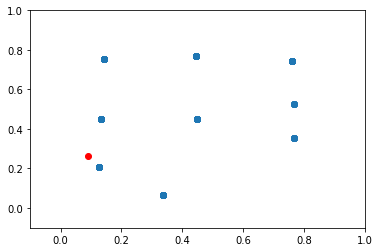

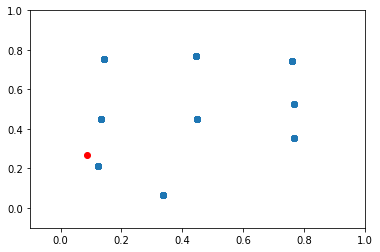

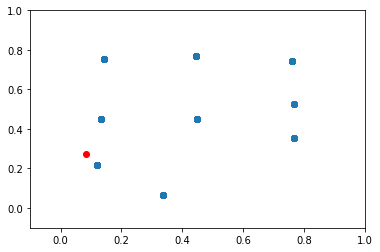

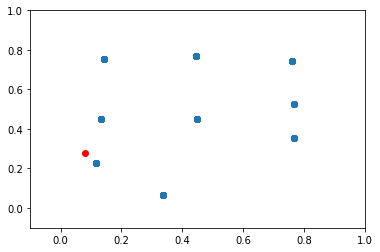

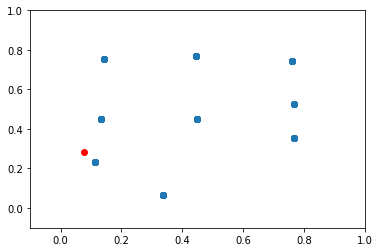

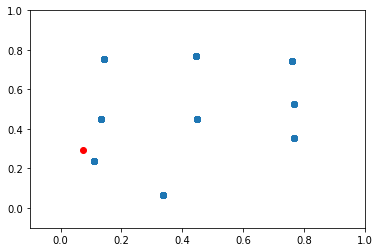

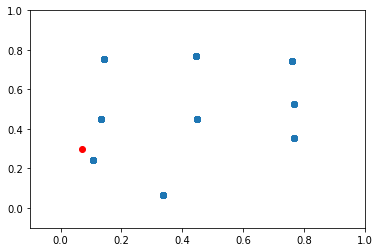

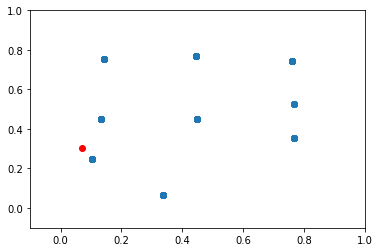

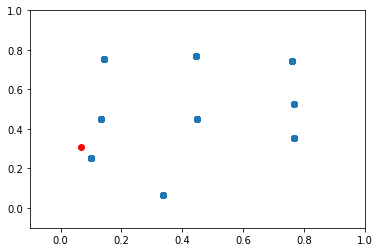

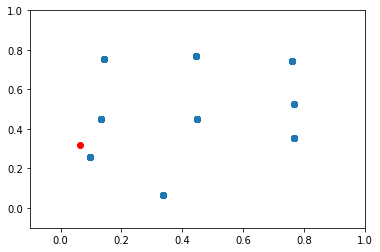

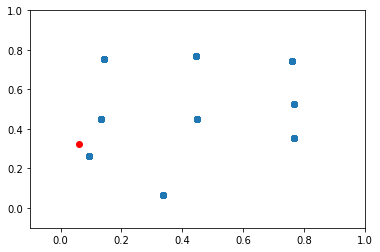

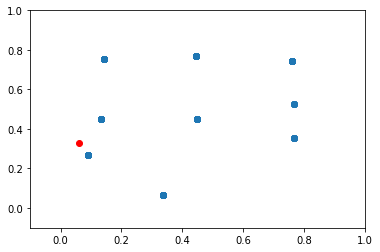

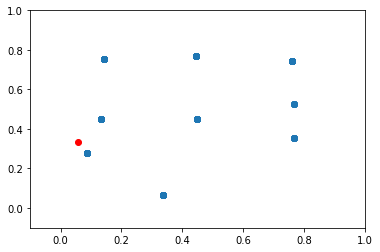

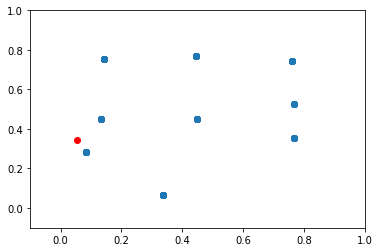

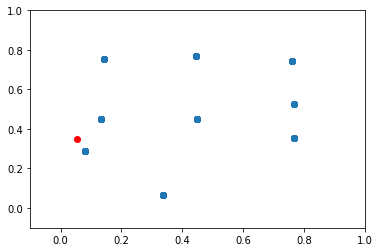

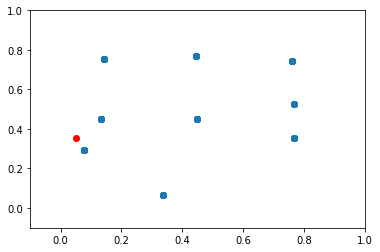

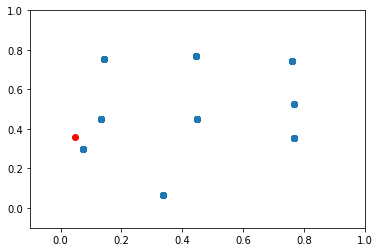

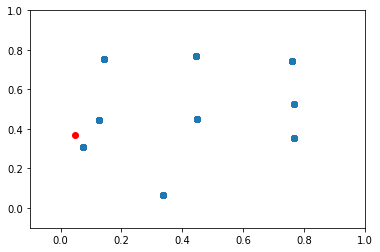

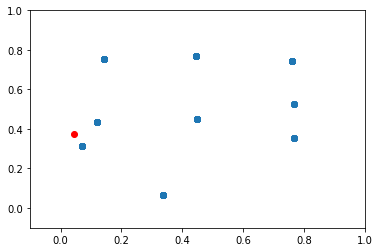

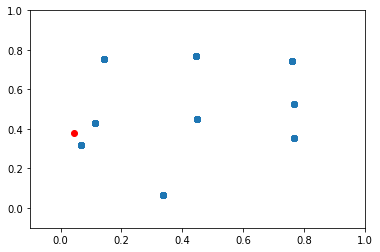

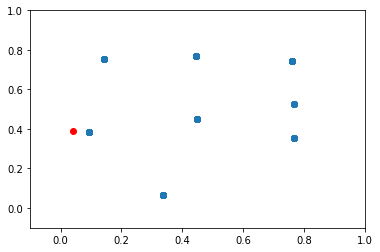

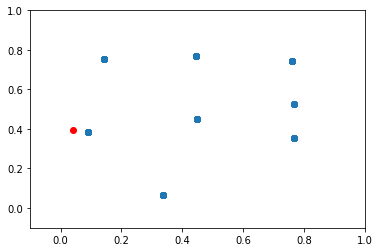

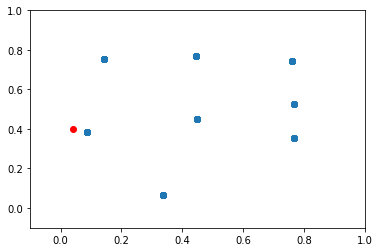

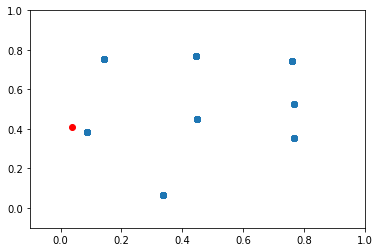

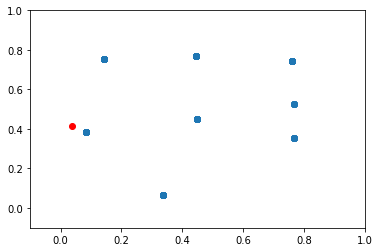

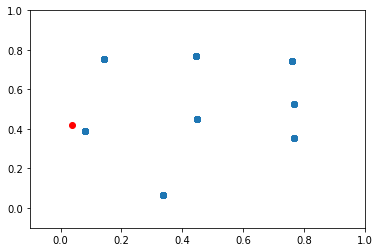

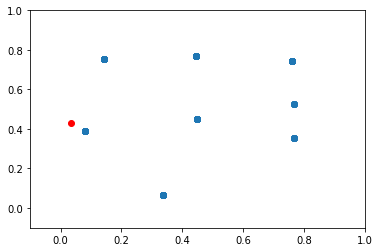

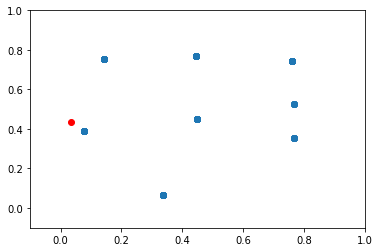

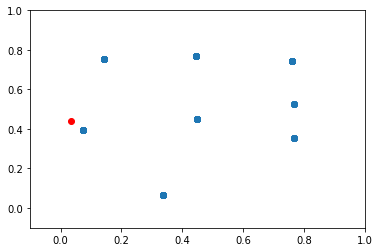

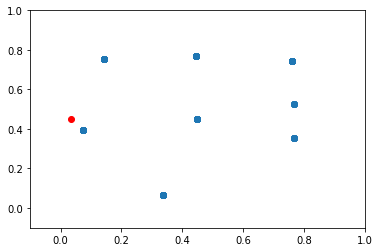

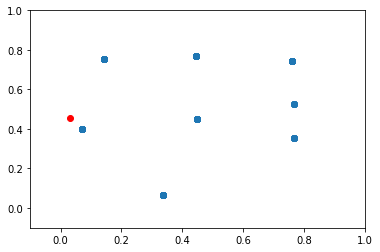

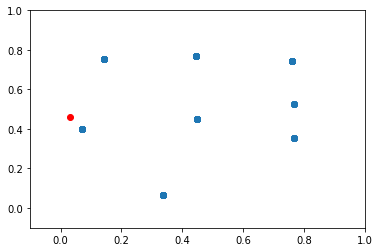

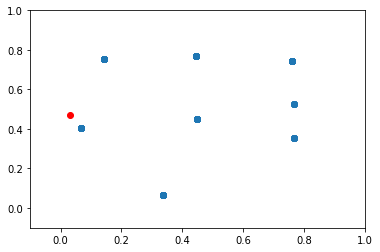

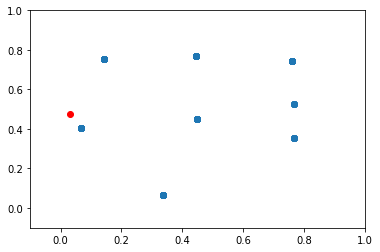

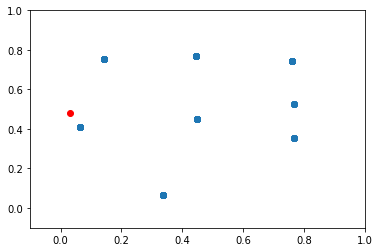

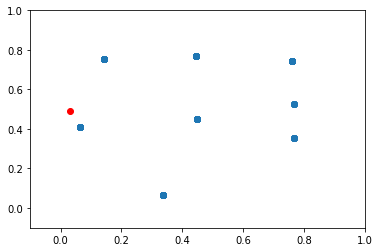

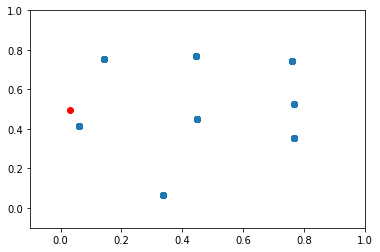

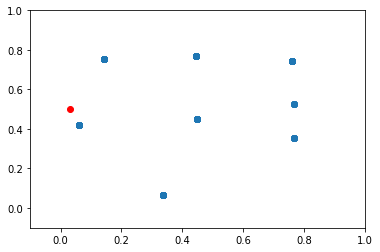

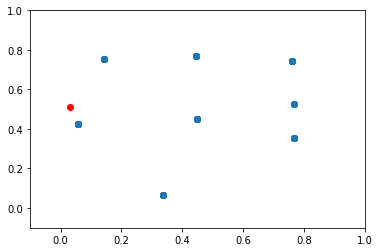

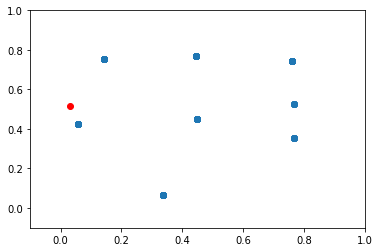

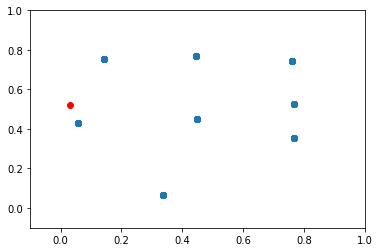

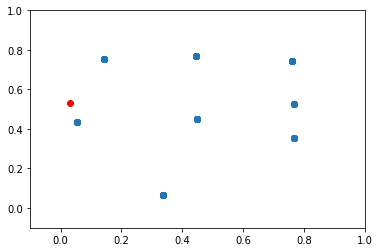

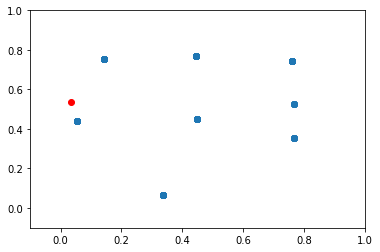

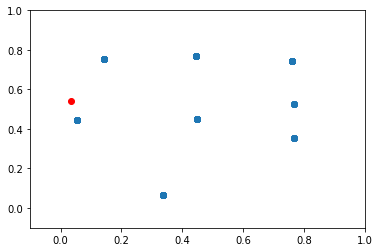

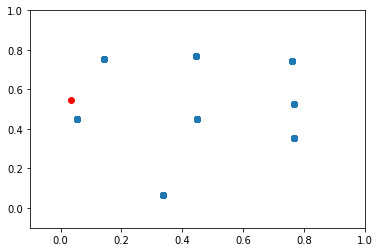

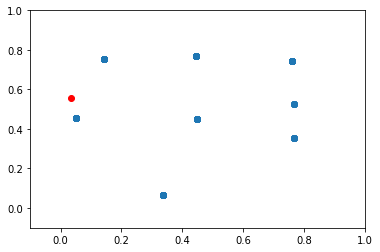

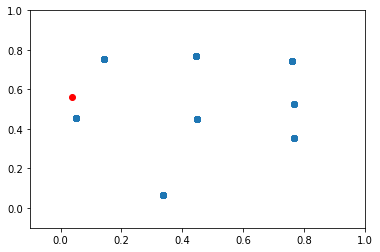

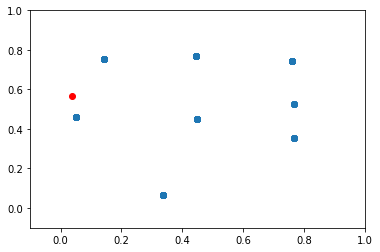

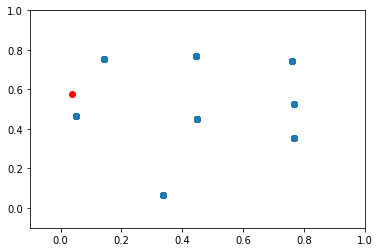

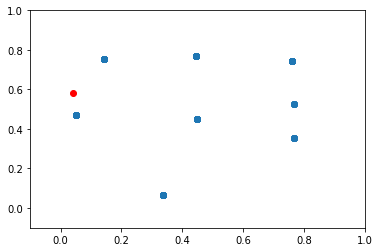

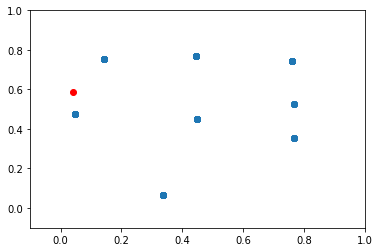

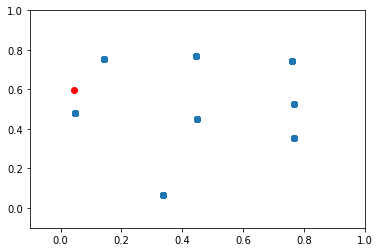

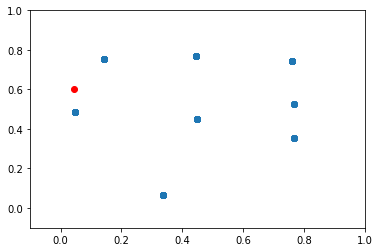

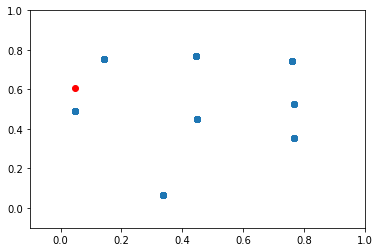

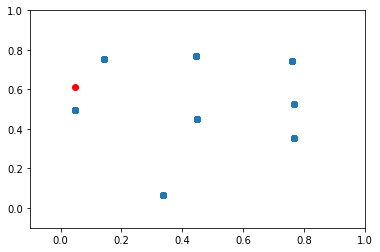

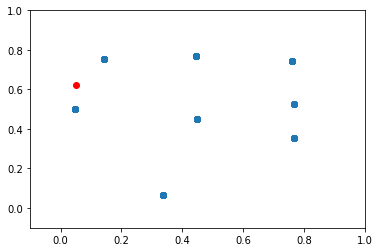

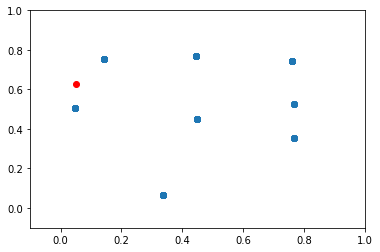

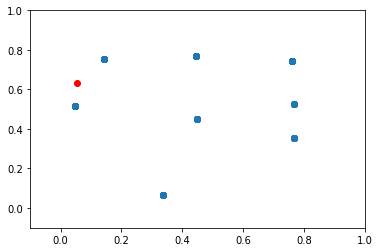

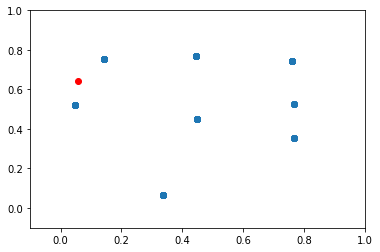

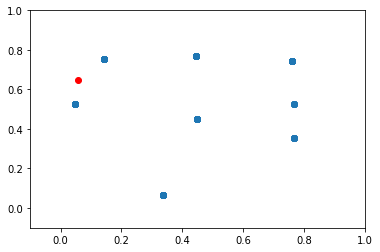

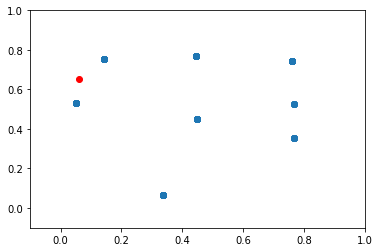

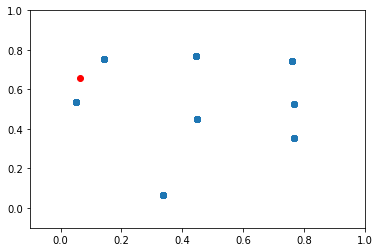

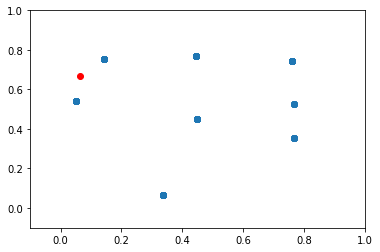

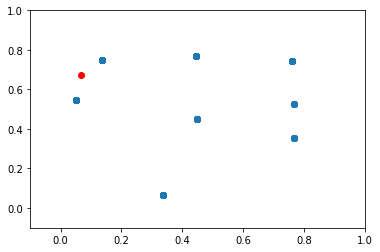

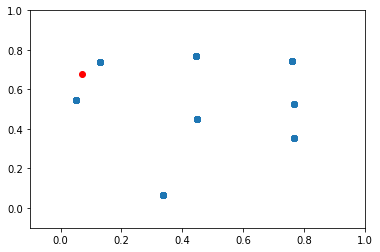

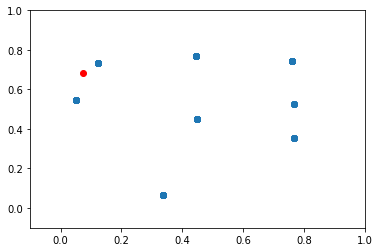

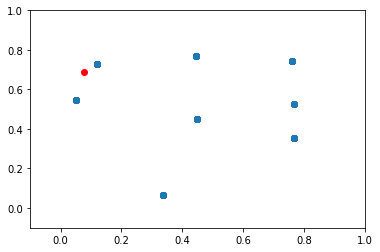

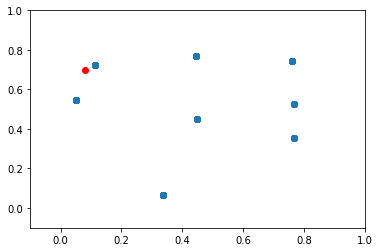

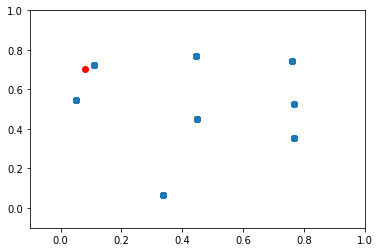

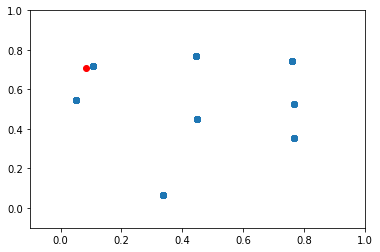

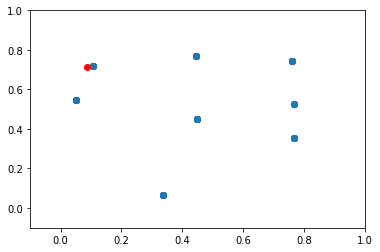

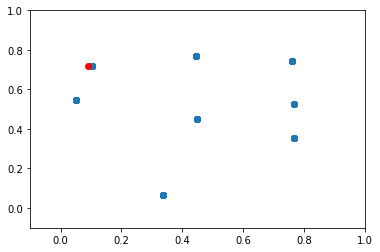

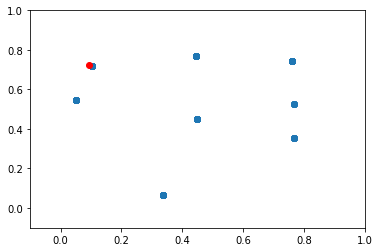

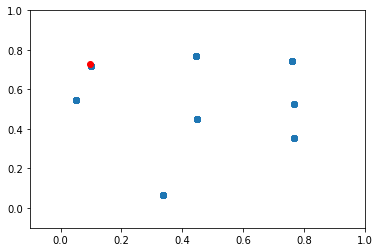

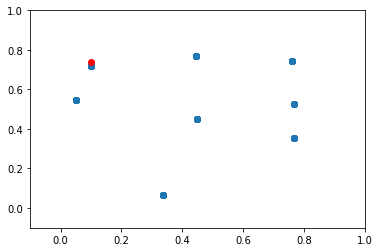

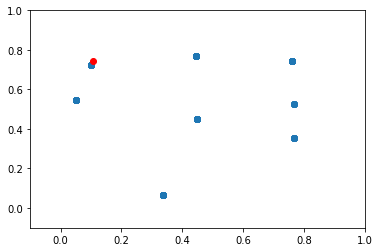

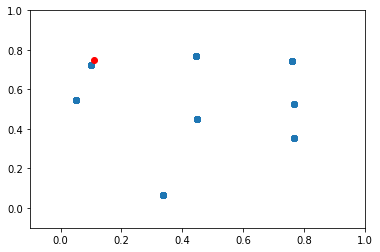

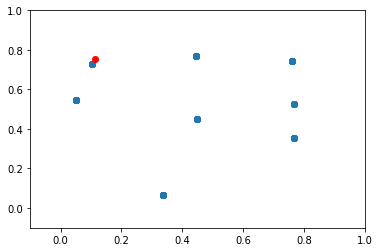

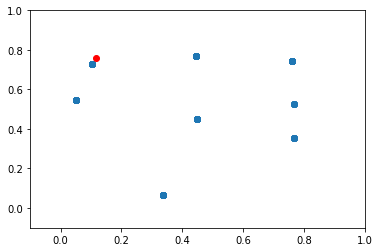

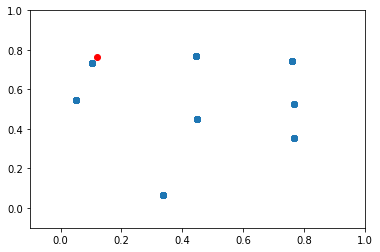

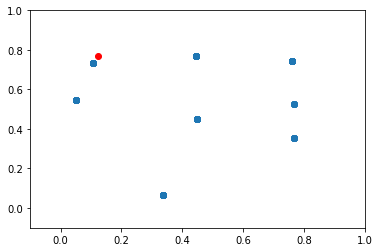

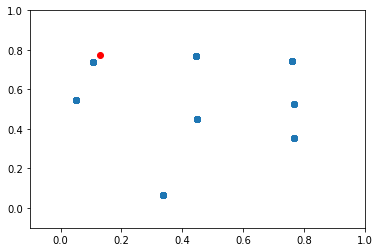

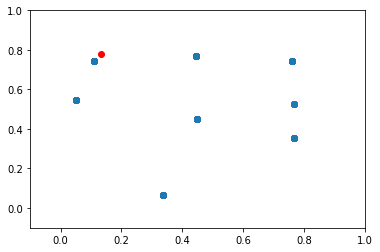

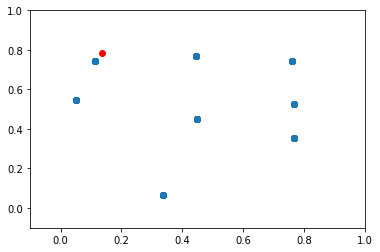

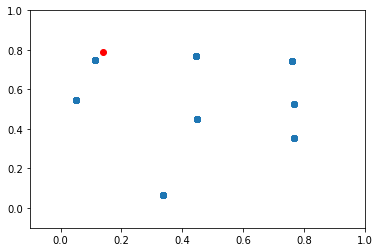

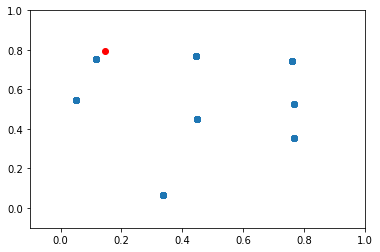

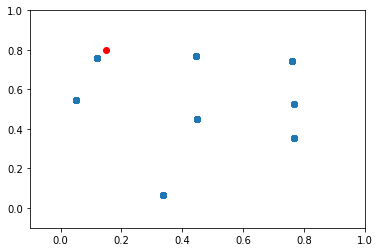

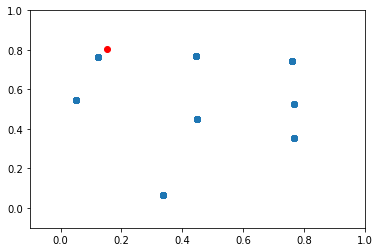

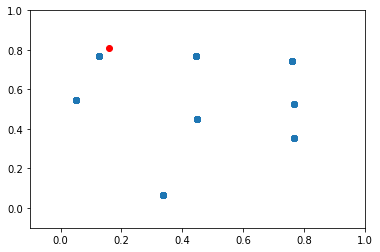

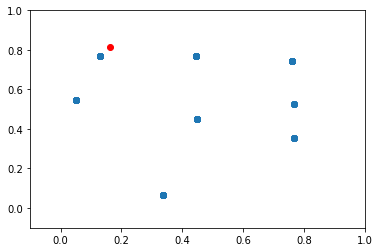

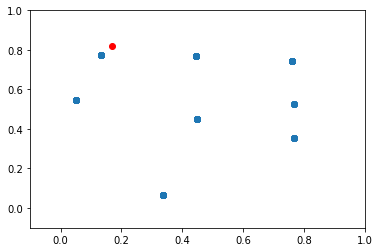

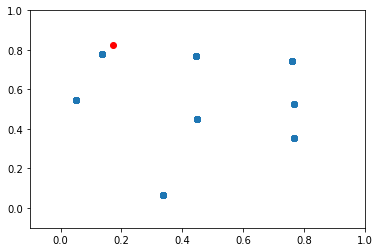

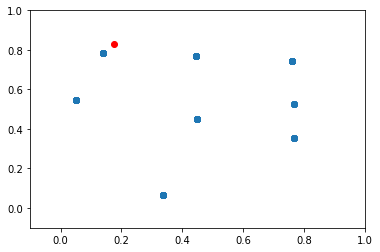

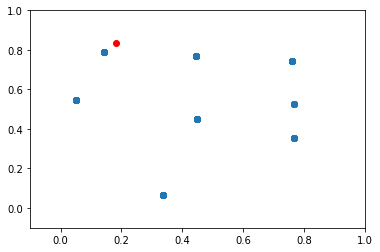

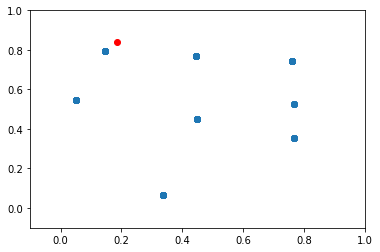

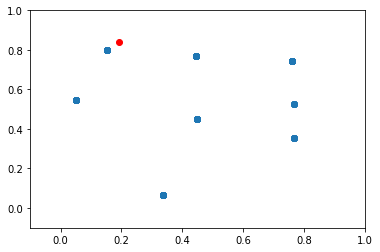

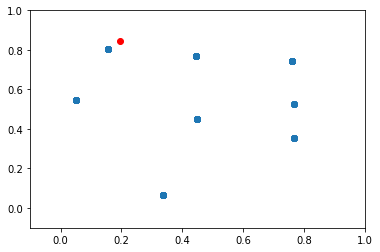

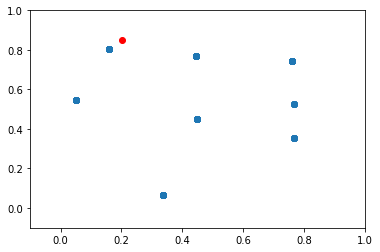

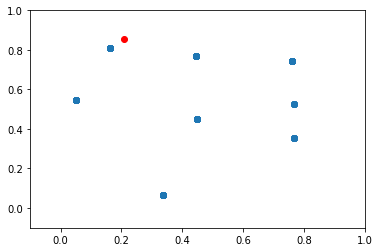

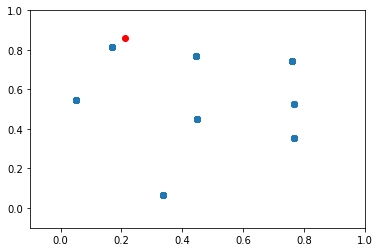

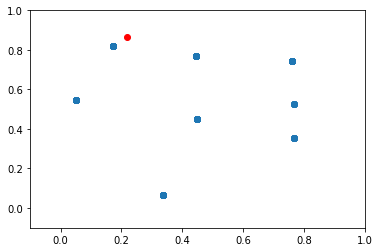

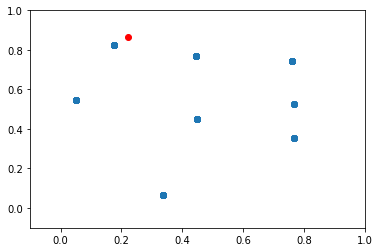

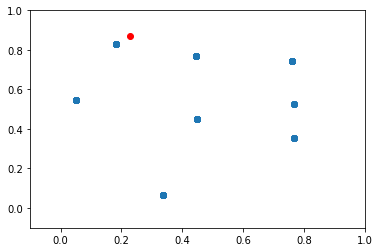

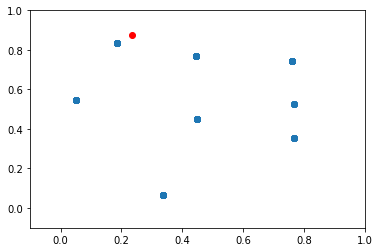

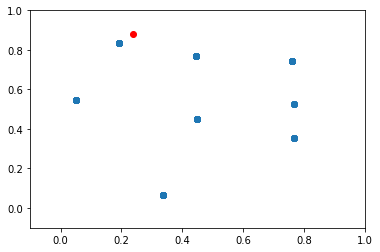

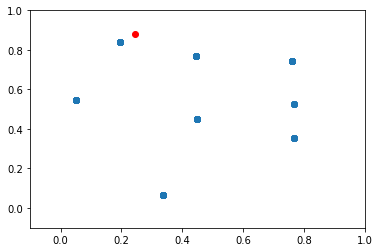

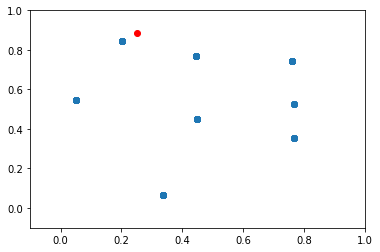

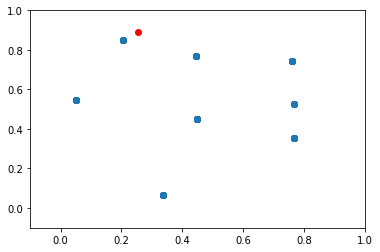

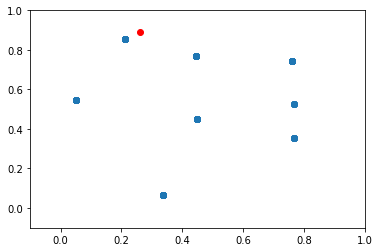

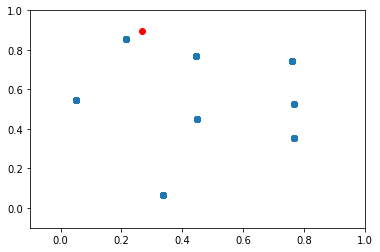

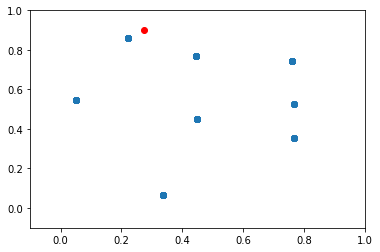

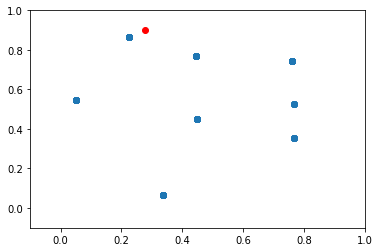

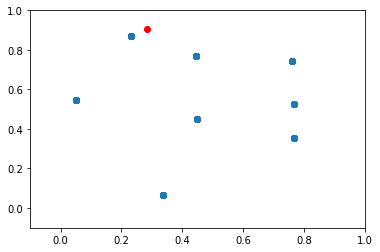

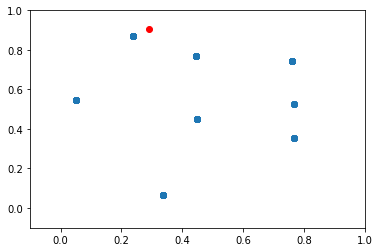

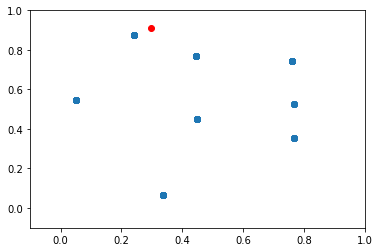

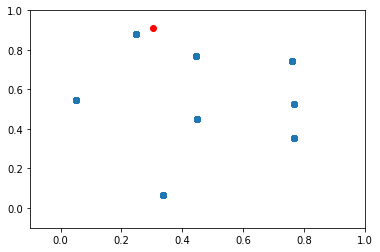

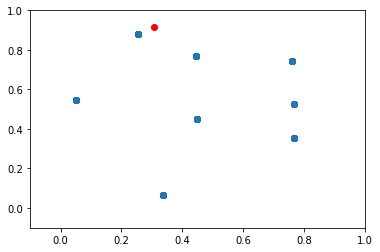

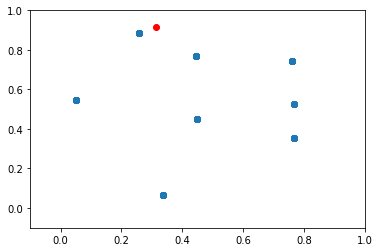

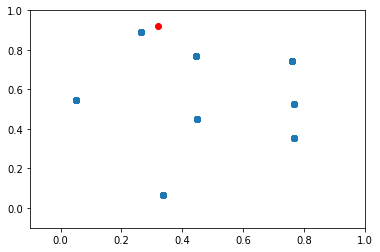

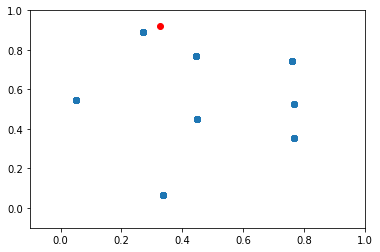

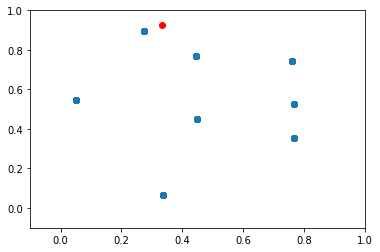

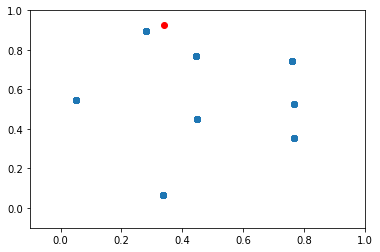

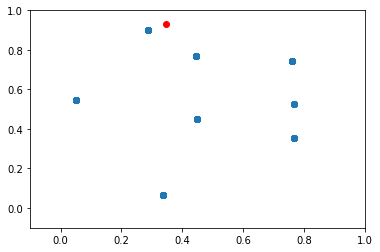

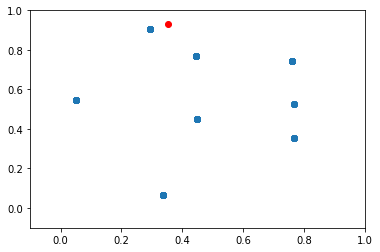

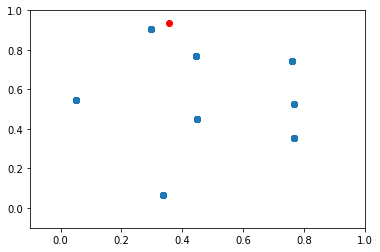

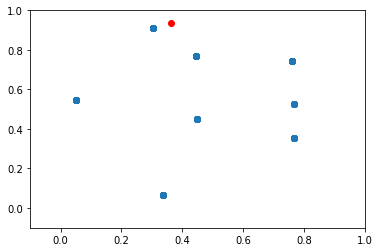

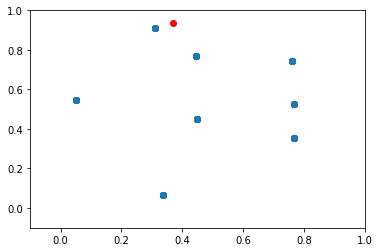

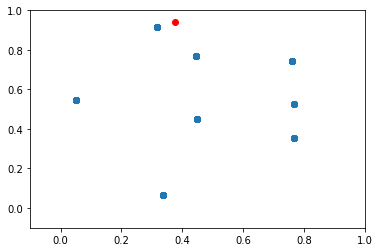

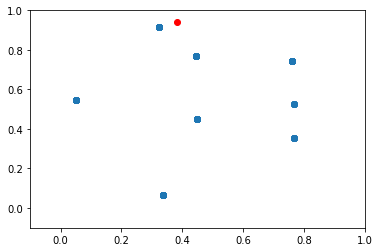

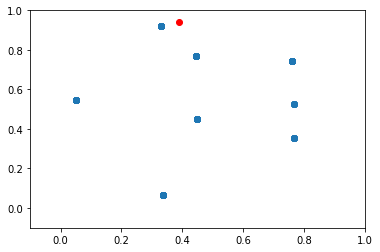

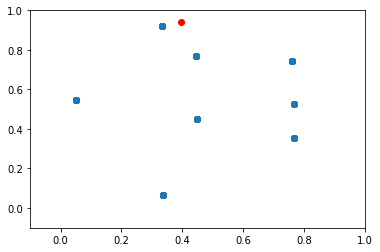

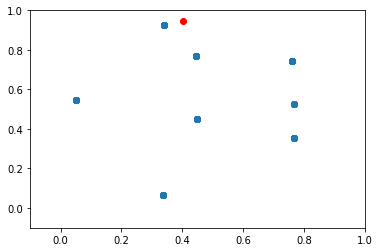

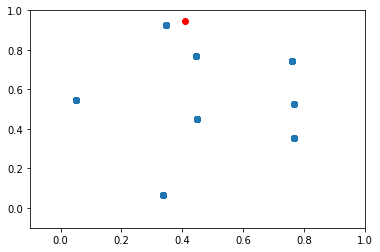

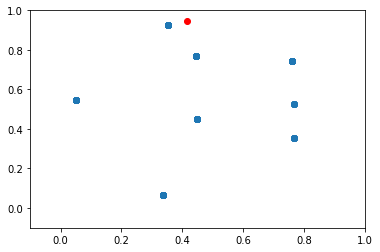

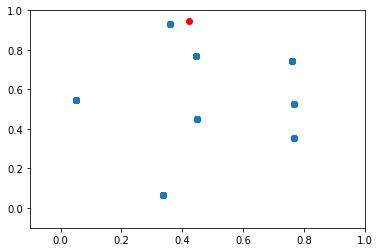

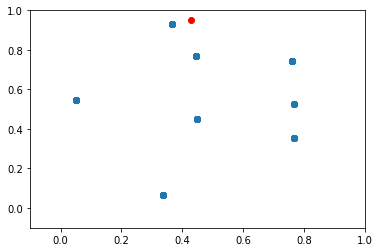

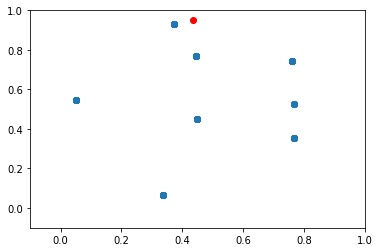

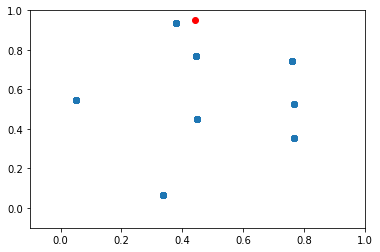

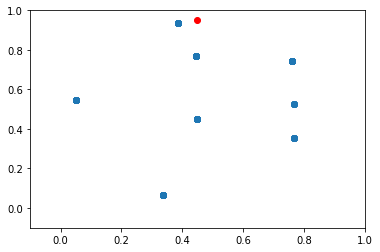

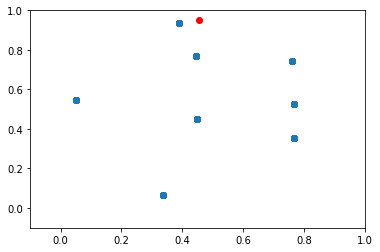

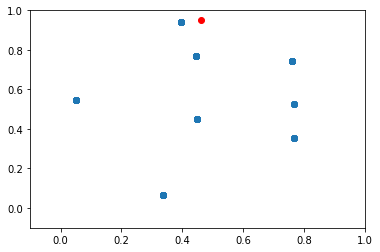

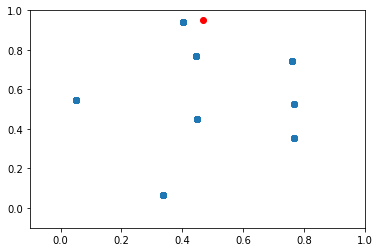

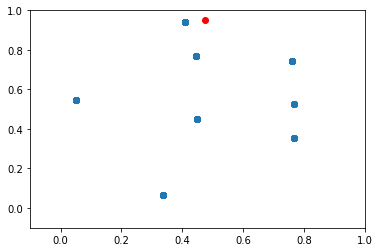

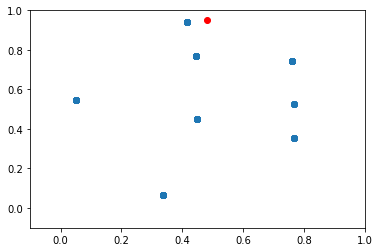

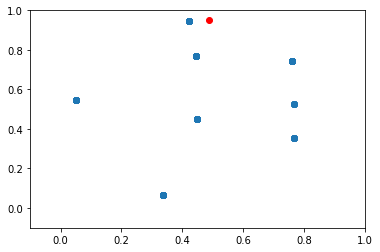

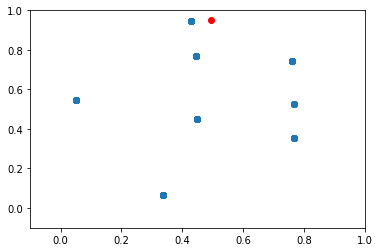

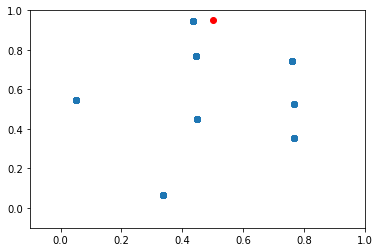

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [10]:
for res in res_arr:
    plt.scatter(res[:-1, 0], res[:-1, 1])
    plt.plot(res[-1, 0], res[-1, 1], 'o', color='r')
    plt.ylim(-0.1, 1)
    plt.xlim(-0.1, 1)
    plt.show()

In [142]:
res_arr.shape

(1001, 401, 2)

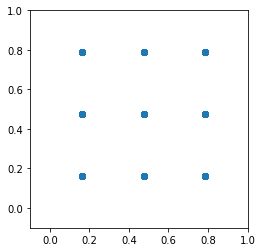

In [63]:
import numpy as np
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

Figure = plt.figure()

plt.gca().set_aspect('equal')
# creating a plot
scat = plt.scatter(res_arr[0, :, 0], res_arr[0, :, 1]) 
 
plt.xlim(-0.1,1.0)  
plt.ylim(-0.1,1.0)   

def AnimationFunction(frame):
    offsets = []
    scat.set_offsets([x for x in res_arr[frame]])
    return scat,

anim_created = FuncAnimation(Figure, AnimationFunction, frames=res_arr.shape[0])

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=5,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
anim_created.save('scatter.gif', writer=writer)


In [47]:
def draw_HK_2D_simulation(res_arr, cmap=None):
    plt.figure(figsize=(10,10))
    N = res_arr.shape[1]
    steps = res_arr.shape[0]
    plt.gca().set_aspect('equal')
    if cmap:
        cmap = mp.cm.get_cmap(cmap)
        norm=plt.Normalize(vmin=0, vmax=N)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    
    for i in trange(N):
        if cmap:   
            color=np.array(cmap(norm(i)))*0.9
        else:
            color = np.random.random(3)*0.7
        if i == N - 1:
            color = 'red'

        # plt.plot(res_arr[:, i, 0], res_arr[:, i, 1], '->', alpha = 0.5, color = color )
        for t in range(steps-1):
            plt.arrow(res_arr[t,i,0], res_arr[t,i,1], res_arr[t+1,i,0]-res_arr[t,i,0], res_arr[t+1,i,1]-res_arr[t,i,1],
                      head_width=0.01, head_length=0.01, fc=color, ec=color, alpha=0.5)

    plt.scatter(res_arr[-1, :, 0], res_arr[-1, :, 1], label = 'final clusters')
    plt.ylabel('y opinion')
    plt.xlabel('x opinion')
    plt.legend(loc="upper right")
    # plt.grid(True)
    plt.show()

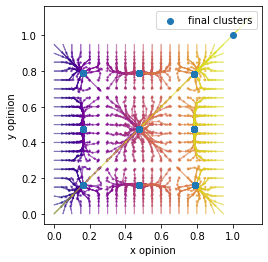

In [135]:
draw_HK_2D_simulation(res_arr, 'plasma')

## Спиральная траектория

In [26]:
@njit()
def HK_2D_step_control_spiral(pos_arr, R, pos_target):
    '''
    Returns new potion of particles based on neighbors in circle of radius R
    '''
    N = len(pos_arr)
    pos_new = np.zeros((N, 2))
    for i in range(N-1):
        res_pos = np.array([0.0, 0.0])
        count = 0
        for j in range(N):
            if (np.linalg.norm(pos_arr[i] - pos_arr[j]) <= R):
                res_pos += pos_arr[j]
                count += 1

        pos_new[i] = res_pos / count
    pos_new[-1] = pos_target.copy()
    
    return pos_new


def HK_2D_sim_control_spiral(pos_init, R, eps, max_iter):
    '''
    Simulates HK model for 2D particles
    '''
    # target agent's opinions
    x = []
    y = []
    for theta in np.linspace(0, 16*np.pi, 1500):
        r = R / (4*np.pi) * theta
        x.append(r*np.cos(theta)+0.5)
        y.append(r*np.sin(theta)+0.5)
    
    coor_target = np.vstack([x, y]).T[-1::-1, :]

    pos = pos_init.copy()
    pos_t_array = np.empty((0, pos.shape[0], pos.shape[1]), dtype=np.float64)
    pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    for i in trange(max_iter):
        if i < coor_target.shape[0]:
            pos_new = HK_2D_step_control_spiral(pos, R, coor_target[i])
        else:
            pos_new = HK_2D_step_control_spiral(pos, R, coor_target[-1])
        if np.linalg.norm(pos_new - pos) < eps:
            break
        pos = pos_new
        pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    return pos_t_array, i != max_iter - 1

In [27]:
n = 10
S = 1.0
N = n ** 2
init_pos = np.zeros((N, 2), dtype=float)
R = 0.125 + 0.000001
for i in range(n):
    for j in range(n):
        init_pos[i * n + j] = [i / n * S, j / n * S]
        
init_pos = np.vstack([init_pos, np.array([(R * 4.) * np.cos(16*np.pi)+0.5, (R * 4.) * np.sin(16*np.pi)+0.5])])


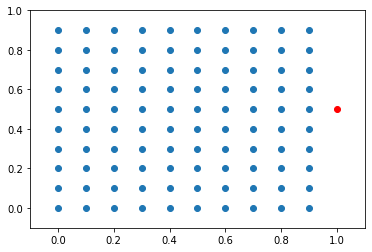

In [52]:
plt.scatter(init_pos[:-1, 0], init_pos[:-1, 1])
plt.plot(init_pos[-1, 0], init_pos[-1, 1], 'o', color='r')
plt.ylim(-0.1, 1)
plt.xlim(-0.1, 1.1)
plt.show()

In [29]:
init_pos[-1]

array([1.000004, 0.5     ])

In [30]:
init_pos.shape

(101, 2)

In [31]:
res_arr, check = HK_2D_sim_control_spiral(init_pos, R, R * 1e-3, 4000)
assert(check)

 44%|████▍     | 1776/4000 [00:22<00:27, 80.45it/s]


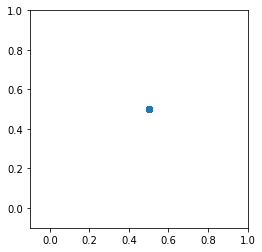

In [32]:
import numpy as np
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt

Figure = plt.figure()

plt.gca().set_aspect('equal')
# creating a plot
scat = plt.scatter(res_arr[0, :, 0], res_arr[0, :, 1]) 
 
plt.xlim(-0.1,1.0)  
plt.ylim(-0.1,1.0)   

def AnimationFunction(frame):
    offsets = []
    scat.set_offsets([x for x in res_arr[frame]])
    return scat,

anim_created = FuncAnimation(Figure, AnimationFunction, frames=res_arr.shape[0])

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=160,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
anim_created.save('scatter.gif', writer=writer)


In [2]:
with open('res_arr_spiral_100.npy', 'wb') as f:
    np.save(f, res_arr)

NameError: name 'res_arr' is not defined

In [ ]:
with open('res_arr_spiral.npy', 'wb') as f:
    np.save(f, res_arr)

100%|██████████| 101/101 [01:20<00:00,  1.26it/s]


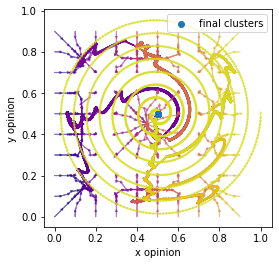

In [35]:
draw_HK_2D_simulation(res_arr, 'plasma')

100%|██████████| 101/101 [00:08<00:00, 12.07it/s]


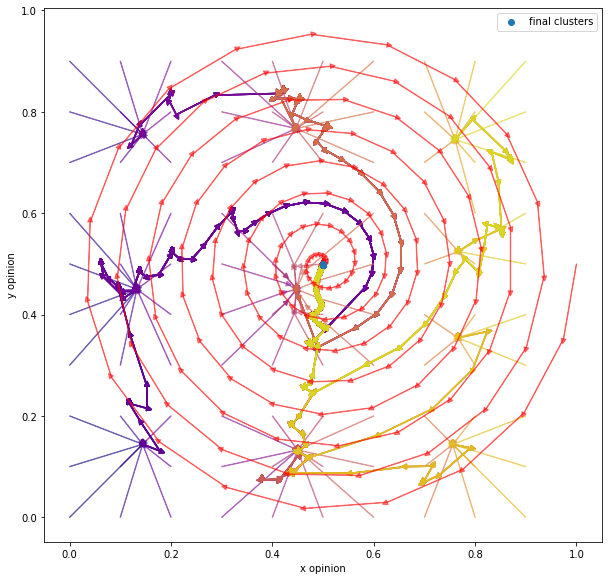

In [48]:
draw_HK_2D_simulation(res_arr[::10,:], 'plasma')

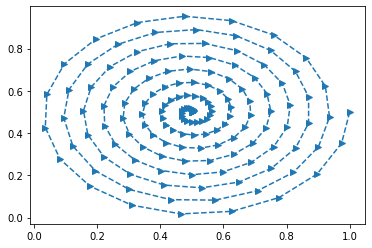

In [57]:
plt.plot(res_arr[::10, -1, 0], res_arr[::10, -1, 1], '-->')

In [46]:
res_arr[-1, ::50]

array([[0.4995781 , 0.49881326],
       [0.4995781 , 0.49881326],
       [0.5       , 0.5       ]])

## "Челнок"

In [ ]:
@njit()
def HK_2D_step_control_runner(pos_arr, R):
    '''
    Returns new potion of particles based on neighbors in circle of radius R
    '''
    N = len(pos_arr)
    pos_new = np.zeros((N, 2))
    for i in range(N-1):
        res_pos = np.array([0.0, 0.0])
        count = 0
        for j in range(N):
            if (np.linalg.norm(pos_arr[i] - pos_arr[j]) <= R):
                res_pos += pos_arr[j]
                count += 1

        pos_new[i] = res_pos / count
    pos_new[-1] = pos_target.copy()
    
    return pos_new


def HK_2D_sim_control_runner(pos_init, R, eps, max_iter):
    '''
    Simulates HK model for 2D particles
    '''
#     # target agent's opinions
#     x = []
#     y = []
#     for theta in np.linspace(0, 8*np.pi, 3000):
#         r = R / (2*np.pi) * theta
#         x.append(r*np.cos(theta)+0.5)
#         y.append(r*np.sin(theta)+0.5)
    
#     coor_target = np.vstack([x, y]).T[-1::-1, :]

    pos = pos_init.copy()
    pos_t_array = np.empty((0, pos.shape[0], pos.shape[1]), dtype=np.float64)
    pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    for i in trange(max_iter):
        pos_new = HK_2D_step_control_runner(pos, R)
        if np.linalg.norm(pos_new - pos) < eps:
            break
        pos = pos_new
        pos_t_array = np.append(pos_t_array, np.array([pos.copy()]), axis=0)
    return pos_t_array, i != max_iter - 1